# Tessellations network + Boeing network join Part 2

The Boeing network is a more simplified version of the OSMnx network. However, the Tessellations network covers zones that the Boeing network doesn't.
This notebook explores a way to join to expand couverture in uncovered zones by joining parts of the Tessellations network to the Boeing network.

__Part 2__ focuses on __joining both networks__ using previously created uncovered_network and contact_nodes gdfs (Part 1).

## Import libraries

In [1]:
accesibilidad_urbana = "../../../"

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

# To know if it is a LineString or a MultiLineString, and create them
from shapely.geometry import LineString, MultiLineString
# For calculate distance between points
import math
# To split a line using a point in that line
from shapely.ops import split

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(accesibilidad_urbana))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Notebook config

In [3]:
# Projection to be used whenever necessary
projected_crs = "EPSG:32618"

# Save plots in output > figures > volvo > networks_join
save_plots = False
savefig_dir = accesibilidad_urbana+"output/figures/volvo/networks_join/part_2/"

# Boeing input network (base network)
boeing_nodes_dir = accesibilidad_urbana+ "data/external/volvo/input_boeing_network/moravia_LH_boeing_nodes.shp"
boeing_edges_dir = accesibilidad_urbana+ "data/external/volvo/input_boeing_network/moravia_LH_boeing_edges.shp"

# Tessellations input network (complementary network)
#tess_nodes_dir = accesibilidad_urbana+ "data/external/volvo/output_tessellations_network/moravia_LH_tessellations_nodes_f.gpkg" #From ntbk 06.
#tess_edges_dir = accesibilidad_urbana+ "data/external/volvo/output_tessellations_network/moravia_LH_tessellations_edges_f.gpkg" #From ntbk 06.

# Part 1 input network (From ntbk 08)
latest_iteration_dir = accesibilidad_urbana+ "data/external/volvo/output_networks_join/identify_uncovered_v5/"

comp_uncovered_nodes_dir = latest_iteration_dir + "complementary_uncovered_nodes_dist10.gpkg"
comp_uncovered_edges_dir = latest_iteration_dir + "complementary_uncovered_edges_dist10.gpkg"
contact_nodes_dir = latest_iteration_dir + "contact_nodes_dist10.gpkg"

# Show dirs
print(boeing_nodes_dir)
print(boeing_edges_dir)
print(comp_uncovered_nodes_dir)
print(comp_uncovered_edges_dir)
print(contact_nodes_dir)

../../../data/external/volvo/input_boeing_network/moravia_LH_boeing_nodes.shp
../../../data/external/volvo/input_boeing_network/moravia_LH_boeing_edges.shp
../../../data/external/volvo/output_networks_join/identify_uncovered_v5/complementary_uncovered_nodes_dist10.gpkg
../../../data/external/volvo/output_networks_join/identify_uncovered_v5/complementary_uncovered_edges_dist10.gpkg
../../../data/external/volvo/output_networks_join/identify_uncovered_v5/contact_nodes_dist10.gpkg


## Input data

In [4]:
# Load nodes data
boeing_nodes = gpd.read_file(boeing_nodes_dir)

# Set CRS
if boeing_nodes.crs != projected_crs:
    try:
        boeing_nodes = boeing_nodes.set_crs(projected_crs)
        print("Set CRS to projected_crs.")
    except:
        boeing_nodes = boeing_nodes.to_crs(projected_crs)
        print("Transformed CRS to projected_crs.")

# Filter and rename data
print(list(boeing_nodes.columns))
boeing_nodes.reset_index(inplace=True)
boeing_nodes = boeing_nodes[['ID','geometry']]
boeing_nodes.rename(columns={'ID':'osmid'},inplace=True)

# Set unique identifiers to int
boeing_nodes['osmid'] = boeing_nodes['osmid'].astype('int')

# Show
print(boeing_nodes.crs)
print(boeing_nodes.shape)
boeing_nodes.head(2)

Transformed CRS to projected_crs.
['ID', 'coord_X', 'coord_Y', 'coord_Z', 'Type', 'geometry']
EPSG:32618
(743, 2)


,osmid,geometry
0,344191636,POINT (437449.345 692995.293)
1,344191639,POINT (437370.198 692566.062)


In [5]:
# Load edges data
boeing_edges = gpd.read_file(boeing_edges_dir)

# Set CRS
if boeing_edges.crs != projected_crs:
    try:
        boeing_edges = boeing_edges.set_crs(projected_crs)
        print("Set CRS to projected_crs.")
    except:
        boeing_edges = boeing_edges.to_crs(projected_crs)
        print("Transformed CRS to projected_crs.")

# Filter and rename data
print(list(boeing_edges.columns))
boeing_edges.reset_index(inplace=True)
boeing_edges['key'] = 0
boeing_edges = boeing_edges[['from','to','key','geometry']]
boeing_edges.rename(columns={'from':'u','to':'v'},inplace=True)

# Set unique identifiers to int
boeing_edges['u'] = boeing_edges['u'].astype('int')
boeing_edges['v'] = boeing_edges['v'].astype('int')
boeing_edges['key'] = boeing_edges['key'].astype('int')

# Show
print(boeing_edges.crs)
print(boeing_edges.shape)
boeing_edges.head(2)

Transformed CRS to projected_crs.
['ID', 'from', 'to', 'length', 'grade_abs', 'speed', 'time', 'Type', 'geometry']
EPSG:32618
(1077, 4)


,u,v,key,geometry
0,344191636,344297704,0,"LINESTRING (437449.345 692995.293, 437415.442 ..."
1,344191636,429632637,0,"LINESTRING (437449.345 692995.293, 437544.786 ..."


In [6]:
# Load complementary uncovered nodes data
comp_uncovered_nodes = gpd.read_file(comp_uncovered_nodes_dir)

# Set CRS
if comp_uncovered_nodes.crs != projected_crs:
    try:
        comp_uncovered_nodes = comp_uncovered_nodes.set_crs(projected_crs)
        print("Set CRS to projected_crs.")
    except:
        comp_uncovered_nodes = comp_uncovered_nodes.to_crs(projected_crs)
        print("Transformed CRS to projected_crs.")

# Set unique identifiers to int
comp_uncovered_nodes['osmid'] = comp_uncovered_nodes['osmid'].astype('int')

# Show
print(comp_uncovered_nodes.crs)
print(comp_uncovered_nodes.shape)
comp_uncovered_nodes.head(2)

EPSG:32618
(683, 3)


,osmid,clipping_i,geometry
0,0,0.0,POINT (437387.239 692067.632)
1,1,0.0,POINT (437436.817 692056.015)


In [7]:
# Load complementary uncovered edges data
comp_uncovered_edges = gpd.read_file(comp_uncovered_edges_dir)

# Set CRS
if comp_uncovered_edges.crs != projected_crs:
    try:
        comp_uncovered_edges = comp_uncovered_edges.set_crs(projected_crs)
        print("Set CRS to projected_crs.")
    except:
        comp_uncovered_edges = comp_uncovered_edges.to_crs(projected_crs)
        print("Transformed CRS to projected_crs.")

# Set unique identifiers to int
comp_uncovered_edges['u'] = comp_uncovered_edges['u'].astype('int')
comp_uncovered_edges['v'] = comp_uncovered_edges['v'].astype('int')
comp_uncovered_edges['key'] = comp_uncovered_edges['key'].astype('int')

# Show
print(comp_uncovered_edges.crs)
print(comp_uncovered_edges.shape)
comp_uncovered_edges.head(2)

EPSG:32618
(693, 7)


,u,v,key,edge_id,clipping_i,original_edge_id,geometry
0,0,1,0,010,0.0,None,"LINESTRING (437387.239 692067.632, 437387.456 ..."
1,0,3,0,030,0.0,None,"LINESTRING (437387.239 692067.632, 437387.456 ..."


In [8]:
# Load contact nodes data
contact_nodes = gpd.read_file(contact_nodes_dir)

# Set CRS
if contact_nodes.crs != projected_crs:
    try:
        contact_nodes = contact_nodes.set_crs(projected_crs)
        print("Set CRS to projected_crs.")
    except:
        contact_nodes = contact_nodes.to_crs(projected_crs)
        print("Transformed CRS to projected_crs.")

# Set unique identifiers to int
contact_nodes['osmid'] = contact_nodes['osmid'].astype('int')

# Show
print(contact_nodes.crs)
print(contact_nodes.shape)
contact_nodes.head(2)

EPSG:32618
(379, 3)


,osmid,clipping_i,geometry
0,4,0.0,POINT (437921.235 692384.410)
1,5,0.0,POINT (438000.016 692369.895)


#### __Input data - Network revision -__ Edges 'u','v' and 'key' revision

Once this is in a Script, it won't be necessary to run this again.
It was ran in part 1.

In [9]:
new_boeing_edges = boeing_edges.copy()

# Find 'u', 'v' and 'key' duplicates in edges (Should never be the case)
duplicated_edges = new_boeing_edges[new_boeing_edges.duplicated(subset=['u', 'v', 'key'], keep=False)]

# Prepare registration_dict. Will hold unique 'u','v' and 'key' assigned.
registration_dict = {}

# For each duplicated edge found:
for index,row in duplicated_edges.iterrows():

    # Current 'u' and 'v'
    current_u = row['u']
    current_v = row['v']
    u_v_id = str(row['u'])+str(row['v'])

    # If current 'u' and 'v' are already registered
    if u_v_id in registration_dict:
        # Read key that has been assigned
        registered_key = registration_dict[u_v_id]
        # Create new unique key
        new_key = registered_key+1
        # Register new unique key and update dictionary
        new_boeing_edges.loc[index,'key'] = new_key
        registration_dict[u_v_id] = new_key
        print(f"Re-registered edge with u {current_u} and v {current_v} with key {new_key}.")

    # Else, it is the first time that this 'u' and 'v' is registered
    else:
        # Register new unique key and update dictionary
        new_boeing_edges.loc[index,'key'] = 0
        registration_dict[u_v_id] = 0
        print(f"Re-registered edge with u {current_u} and v {current_v} with key 0.")

Re-registered edge with u 429636976 and v 429637442 with key 0.
Re-registered edge with u 429636976 and v 429637442 with key 1.
Re-registered edge with u 1072146115 and v 1072146095 with key 0.
Re-registered edge with u 1072146115 and v 1072146095 with key 1.
Re-registered edge with u 5480751174 and v 5480751165 with key 0.
Re-registered edge with u 5480751174 and v 5480751165 with key 1.


In [10]:
ntw_01_u = 5480751174
ntw_01_v = 5480751165

test = new_boeing_edges.loc[((new_boeing_edges['u'] == ntw_01_u) & (new_boeing_edges['v'] == ntw_01_v))].copy()
test

,u,v,key,geometry
1047,5480751174,5480751165,0,"LINESTRING (436919.057 693239.373, 436939.943 ..."
1048,5480751174,5480751165,1,"LINESTRING (436919.057 693239.373, 436931.529 ..."


In [11]:
# Update original boeing_edges
boeing_edges = new_boeing_edges.copy()

In [12]:
# EDGE IDs check
edge_ids_check = boeing_edges.copy()

# Create unique ID for each edge using u+v+key
edge_ids_check['u'] = edge_ids_check['u'].astype('str')
edge_ids_check['v'] = edge_ids_check['v'].astype('str')
edge_ids_check['key'] = edge_ids_check['key'].astype('str')
edge_ids_check['edge_id'] = edge_ids_check['u']+edge_ids_check['v']+edge_ids_check['key']
# Return 'u','v' and 'key' to int
edge_ids_check['u'] = edge_ids_check['u'].astype('int')
edge_ids_check['v'] = edge_ids_check['v'].astype('int')
edge_ids_check['v'] = edge_ids_check['v'].astype('int')

# Show
edge_ids_check.head(2)

,u,v,key,geometry,edge_id
0,344191636,344297704,0,"LINESTRING (437449.345 692995.293, 437415.442 ...",3441916363442977040
1,344191636,429632637,0,"LINESTRING (437449.345 692995.293, 437544.786 ...",3441916364296326370


In [13]:
# EDGE IDs check
edge_ids_check = comp_uncovered_edges.copy()

# Create unique ID for each edge using u+v+key
edge_ids_check['u'] = edge_ids_check['u'].astype('str')
edge_ids_check['v'] = edge_ids_check['v'].astype('str')
edge_ids_check['key'] = edge_ids_check['key'].astype('str')
edge_ids_check['edge_id'] = edge_ids_check['u']+edge_ids_check['v']+edge_ids_check['key']
# Return 'u','v' and 'key' to int
edge_ids_check['u'] = edge_ids_check['u'].astype('int')
edge_ids_check['v'] = edge_ids_check['v'].astype('int')
edge_ids_check['v'] = edge_ids_check['v'].astype('int')

# Show
edge_ids_check.head(2)

,u,v,key,edge_id,clipping_i,original_edge_id,geometry
0,0,1,0,010,0.0,None,"LINESTRING (437387.239 692067.632, 437387.456 ..."
1,0,3,0,030,0.0,None,"LINESTRING (437387.239 692067.632, 437387.456 ..."


### __Input data__ - Visualize

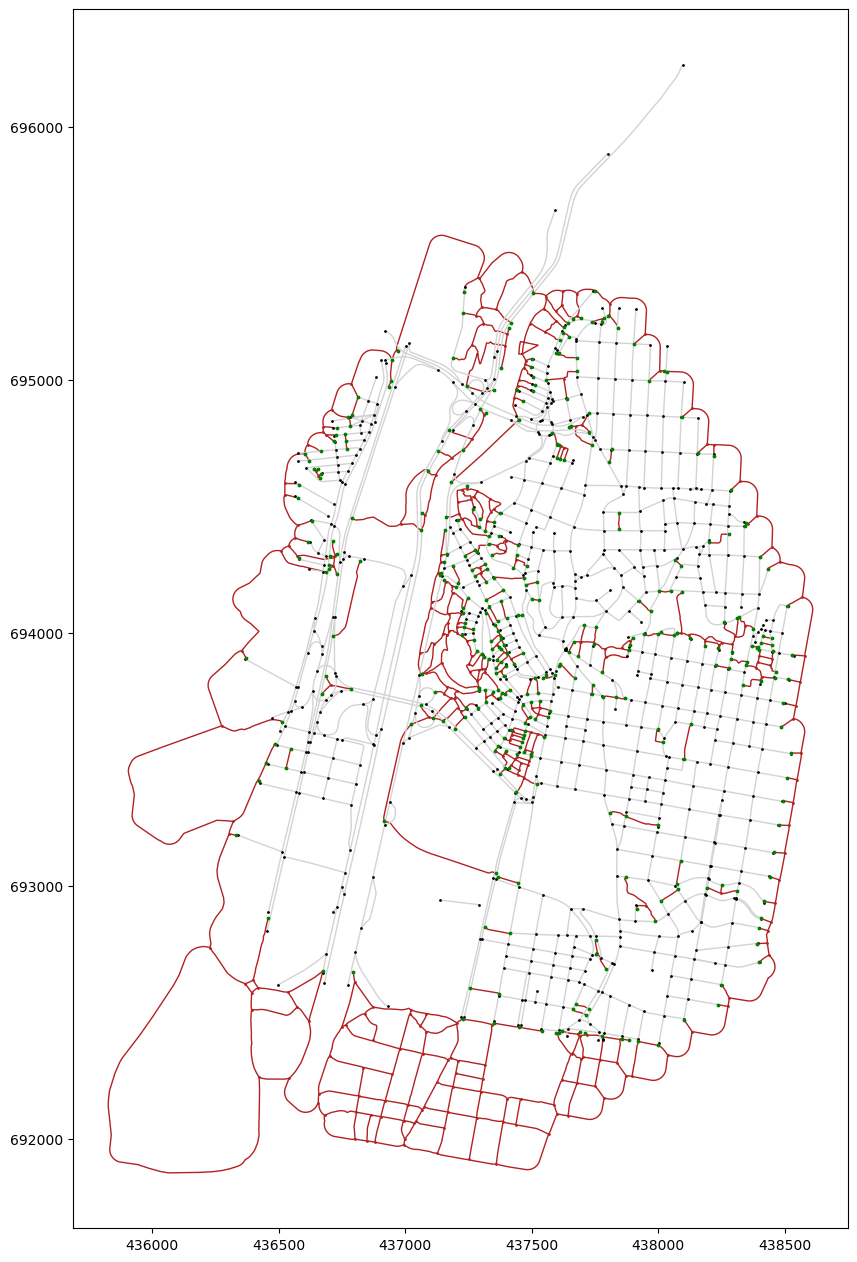

In [14]:
# Plot
fig,ax = plt.subplots(1,1,figsize=(10,20))

contact_nodes.plot(ax=ax, zorder=4, color='green', markersize=3)
boeing_nodes.plot(ax=ax,zorder=3,color='black',markersize=1)
boeing_edges.plot(ax=ax,zorder=2,color='lightgrey',linewidth=1)
comp_uncovered_nodes.plot(ax=ax,zorder=1,color='firebrick',markersize=1)
comp_uncovered_edges.plot(ax=ax,zorder=0,color='firebrick',linewidth=1)

# ---------- Save Plot ----------
if save_plots:
    plt.savefig(savefig_dir + "00_networks_visualization.svg")

## __Previously developed (Part 1) functions__

In [15]:
def produce_osmid(nodes_network_1, nodes_network_2, previously_produced):
    
    stop = False
    produced_osmid = previously_produced
    
    while stop == False:

        # Evaluate if fabricated_osmid exists in any network
        if (produced_osmid in list(nodes_network_1.osmid.unique())) or (produced_osmid in list(nodes_network_2.osmid.unique())):
            # Try the next one
            produced_osmid +=1
            
        else:
            # Reached an unique fabricated_osmid
            stop = True
            return produced_osmid

In [16]:
def edge_clipping(starting_point_gdf, edge_gdf, clipping_point_gdf, projected_crs="EPSG:6372", return_all=False):
    
    """ This function clips an edge by considering a starting point and a clipping point.
    
	Args:
		starting_point_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the starting point of the LineString, helps identify each split part. 
                                                     Requires column 'geometry' with a Point.
        edge_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the edge to be clipped. 
                                           Requires column 'geometry' with a LineString.
        clipping_point_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the clipping point of the LineString.
                                                     Requires column 'geometry' with a Point.
        projected_crs (str, optional): string containing projected crs to be used depending on area of interest. Defaults to "EPSG:6372".
        return_all (bool,optional): Boolean that defines whether the clipped edge is returned from starting_point to clipping_point only (One line) (False)
                                    or returned from starting_point to clipping_point and then from clipping_point to ending_point (Two lines) (True). 
                                    Defaults to False.
                                                 
	Returns:
        split_edge_gdf (geopandas.GeoDataFrame): GeoDataFrame with either one (return_all=False) or two (return_all=True) edges.
	"""
    
    # 1.0 --------------- Split the edge using the clipping_point. Creates two separate edges.
    # Extract the edge's geometry (LineString)
    edge_geom = edge_gdf['geometry'].unique()[0]
    # Extract the clipping_point's geometry (Point)
    clipping_point_geom = clipping_point_gdf['geometry'][0]
    # Project the clipping_point onto the edge (In case it's not drawn exactly in the LineString)
    projected_point = edge_geom.interpolate(edge_geom.project(clipping_point_geom))
    
    # ----- ----- Added code since having trouble clipping with a point ----- -----
    # Create a VERY SMALL buffer around the projected_point
    projected_point = projected_point.buffer(1e-9)
    # ----- ----- Added code since having trouble clipping with a point ----- -----
    
    # Split the edge where the projected clipping_point is
    split_lines = split(edge_geom, projected_point)
    # Convert the split lines to a GeoDataFrame
    split_gdf = gpd.GeoDataFrame(geometry=list(split_lines.geoms), crs=projected_crs)
    
    # ----- ----- Added code since having trouble clipping with a point ----- -----
    # Drop the small split line located inside the VERY SMALL buffer in order to keep the two split lines outside it.
    if len(split_gdf) ==3 :
        split_gdf['length'] = split_gdf.length
        split_gdf = split_gdf.loc[split_gdf.length != split_gdf.length.min()]
    split_gdf.reset_index(inplace=True,drop=True)
    # ----- ----- Added code since having trouble clipping with a point ----- -----

    # 2.0 --------------- Find which split LineString in split_gdf contains the LineString where the starting_point is located
    
    # Extract the edge's first and last coordinates
    edge_coords = list(edge_gdf['geometry'][0].coords)
    first_point_coords = edge_coords[0]
    last_point_coords = edge_coords[-1]
    # Extract the starting_point's coordinates (Function input)
    starting_point_coords = starting_point_gdf.loc[0,'geometry'].coords[0]
    # Try identifying which (first or last) is the starting_point by checking equality in coordinates
    if starting_point_coords == first_point_coords:
        # Starting point is first_point
        starting_point_coords = first_point_coords
    elif starting_point_coords == last_point_coords:
        # Starting point is last_point
        starting_point_coords = last_point_coords
    # Else, measure distance and assume the starting_point is the closest one.
    # (this case applies when starting_point is not drawn exactly in the LineString)
    else:
        # Distance from starting_point to first point
        first_point_distance = distance(first_point_coords, starting_point_coords)
        # Distance from starting_point to last point
        last_point_distance = distance(last_point_coords, starting_point_coords)
        # Find which one is the starting_point
        if first_point_distance < last_point_distance:
            # Starting point is first_point
            starting_point_coords = first_point_coords
        else:
            # Starting point is last_point
            starting_point_coords = last_point_coords
    
    # 3.0 --------------- Select split LineString where the starting_point is.
    
    # Find which line from split_gdf has the starting_point_coords
    # Extract both lines (starting and ending line)
    if starting_point_coords in list(split_gdf.loc[0,'geometry'].coords):
        split_edge_geom_start = split_gdf.loc[0,'geometry'] # Extract first line geometry
        split_edge_geom_end = split_gdf.loc[1,'geometry'] # Second line geometry
        
    elif starting_point_coords in list(split_gdf.loc[1,'geometry'].coords):
        split_edge_geom_start = split_gdf.loc[1,'geometry'] # Extract second line geometry
        split_edge_geom_end = split_gdf.loc[0,'geometry'] # Second line geometry
        
    # Convert to a GeoDataFrame
    split_edge_gdf = gpd.GeoDataFrame()
    split_edge_gdf.loc[0,'geometry'] = split_edge_geom_start
    
    # 4.0 --------------- (Optional) Include split other LineString.
    if return_all:
        split_edge_gdf.loc[1,'geometry'] = split_edge_geom_end
        split_edge_gdf.loc[0,'relation'] = 'starting'
        split_edge_gdf.loc[1,'relation'] = 'ending'

    # Final format
    split_edge_gdf = split_edge_gdf.set_crs(projected_crs)

    return split_edge_gdf

In [17]:
# Distance between two points
def distance(point1, point2):
    return round(math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2), 2)

## __Part 2 - Step 01 -__ Networks intersection

### Networks intersection development

In [16]:
ntw_01_edges = boeing_edges.copy()
ntw_01_nodes = boeing_nodes.copy()

ntw_02_nodes = comp_uncovered_nodes.copy()
ntw_02_edges = comp_uncovered_edges.copy()

In [57]:
print(ntw_01_edges.dtypes)
ntw_01_edges.head(1)

u             object
v             object
key            int64
geometry    geometry
dtype: object


,u,v,key,geometry
0,344191636,344297704,0,"LINESTRING (437449.345 692995.293, 437415.442 ..."


In [58]:
print(ntw_02_edges.dtypes)
ntw_02_edges.head(1)

u                    float64
v                    float64
key                  float64
edge_id               object
clipping_i           float64
original_edge_id      object
geometry            geometry
dtype: object


,u,v,key,edge_id,clipping_i,original_edge_id,geometry
0,0.0,1.0,0.0,010,0.0,None,"LINESTRING (437387.239 692067.632, 437387.456 ..."


#### Create intersecting nodes

In [59]:
# Intersect ntw_01_edges and ntw_02_edges to create intersecting_nodes
# Each intersecting_node contains data from the edges being intersected.
# For ntw_01_edges, columns: u_1, v_1, key_1
# For ntw_02_edges, columns: u_2, v_2, key_2
intersecting_nodes = ntw_01_edges.overlay(ntw_02_edges,how='intersection',keep_geom_type=False)

# Explode multipoints
# If an edge from network "x" cuts an edge from network "y" twice or more [e.g. a straight edge cutting a curved edge], 
# the resulting geometry is a MultiPoint (One point in the first intersection, another for the second and so on).
# In order to avoid assigning the same data to both points, exploding is neccesary.
intersecting_nodes = intersecting_nodes.explode(index_parts=False)
intersecting_nodes.reset_index(inplace=True,drop=True)

# Show
print(intersecting_nodes.shape)
intersecting_nodes.head(2)

(161, 10)


,u_1,v_1,key_1,u_2,v_2,key_2,edge_id,clipping_i,original_edge_id,geometry
0,370059140,370058670,0,260.0,261.0,0.0,2602610,0.0,None,POINT (437354.568 693051.802)
1,5480751174,5480751165,0,260.0,261.0,0.0,2602610,0.0,None,POINT (436922.231 693253.477)


#### Assign unique osmid to each new intersecting_node

In [60]:
intersecting_nodes['osmid'] = 0
previously_produced = 0

# For each intersection between networks (new node)
for index,row in intersecting_nodes.iterrows():
    # Produce a unique osmsid (That doesn't exist in either network)
    produced_osmid = produce_osmid(ntw_01_nodes, ntw_02_nodes, previously_produced)
    # Assign osmid to current intersecting_node
    intersecting_nodes.loc[index,'osmid'] = produced_osmid
    # Since ntw_01_nodes and ntw_02_nodes are not being updated, next time try with next possible osmid
    previously_produced = produced_osmid+1

# Show
print(intersecting_nodes.shape)
intersecting_nodes.head(5)

(161, 11)


,u_1,v_1,key_1,u_2,v_2,key_2,edge_id,clipping_i,original_edge_id,geometry,osmid
0,370059140,370058670,0,260.0,261.0,0.0,2602610,0.0,None,POINT (437354.568 693051.802),9
1,5480751174,5480751165,0,260.0,261.0,0.0,2602610,0.0,None,POINT (436922.231 693253.477),17
2,5480751174,5480751165,1,260.0,261.0,0.0,2602610,0.0,None,POINT (436938.974 693248.887),20
3,427837467,4384449779,0,595.0,596.0,0.0,5955960,0.0,None,POINT (436792.188 694451.550),22
4,428076444,428076423,0,357.0,1023.0,0.0,35710230,1.0,3573580,POINT (436726.054 693789.418),24


In [61]:
local_save = True
output_dir = accesibilidad_urbana + f"data/external/volvo/output_networks_join/part2_step1_intersection/"
if local_save:
    intersecting_nodes.to_file(output_dir + f"networks_intersections.gpkg")

#### Cut the edges with the intersecting_nodes

##### __Edge clipping test__

In [93]:
for idx, node in intersecting_nodes.iterrows():
    
    print(node['u_1'])
    print(node['v_1'])

    # 1.0 --------------- Split the edge using the clipping_point. Creates two separate edges.

    # Extract current intersecting node as a df
    intersecting_node = intersecting_nodes.loc[intersecting_nodes.osmid == node['osmid']].copy()
    intersecting_node.reset_index(inplace=True,drop=True)
    
    # Extract network 01 intersected edge
    intersected_edge = ntw_01_edges.loc[(ntw_01_edges['u'] == node['u_1']) & (ntw_01_edges['v'] == node['v_1'])].copy()
    intersected_edge.reset_index(inplace=True,drop=True)

    # Extract network 01 intersected edge's nodes
    u_node = ntw_01_nodes.loc[(ntw_01_nodes['osmid'] == node['u_1'])].copy()
    u_node.reset_index(inplace=True,drop=True)
    #v_node = ntw_01_nodes.loc[(ntw_01_nodes['osmid'] == node['v_1'])].copy()
    #v_node.reset_index(inplace=True,drop=True)

    # Apply edge_clipping function
    split_edge_gdf = edge_clipping(starting_point_gdf = u_node,
                                   edge_gdf = intersected_edge,
                                   clipping_point_gdf = intersecting_node,
                                   projected_crs = projected_crs,
                                   return_all = True)
    
    break

split_edge_gdf

370059140
370058670


,geometry,relation
0,"LINESTRING (437430.913 693331.956, 437429.792 ...",starting
1,"LINESTRING (437354.568 693051.802, 437348.397 ...",ending


<Axes: >

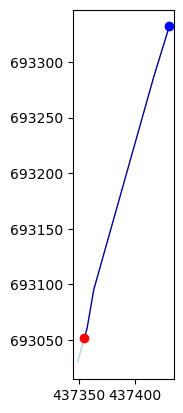

In [94]:
u_edge = split_edge_gdf.loc[split_edge_gdf.relation=='starting'].copy()
v_edge = split_edge_gdf.loc[split_edge_gdf.relation=='ending'].copy()

fig,ax = plt.subplots()

u_node.plot(ax=ax,zorder=2,color='blue')
intersecting_node.plot(ax=ax,zorder=2,color='red')
u_edge.plot(ax=ax,zorder=1,color='darkblue',linewidth=1)
v_edge.plot(ax=ax,zorder=1,color='lightblue',linewidth=1)

##### __Split and update network_01__

In [22]:
ntw_01_edges_split = ntw_01_edges.copy()
ntw_01_nodes_split = ntw_01_nodes.copy()

extended_logs = False

for idx, node in intersecting_nodes.iterrows():

    # 1.0 --------------- Split the ntw_01 intersected edge using the intersecting_node as clipping_point. 
    # ------------------- This split (Using function edge_clipping()) creates two separate edges:
    # ------------------- The first edge is related to the starting_point_gdf (ntw_01_u node)
    # ------------------- The second edge is related to the opposite side (ntw_01_v node)

    # Current intersecting_node's data
    intersecting_node_osmid = node['osmid']
    ntw_01_u = node['u_1']
    ntw_01_v = node['v_1']
    ntw_01_key = node['key_1']

    if extended_logs:
        print(f"Intersecting with new intersecting node osmid {intersecting_node_osmid}.") #Debugging check
        print(f"Edge with u {ntw_01_u} type {type(ntw_01_u)}.") #Debugging check
        print(f"Edge with v {ntw_01_v} type {type(ntw_01_v)}.") #Debugging check
        print(f"Edge with key {ntw_01_key} type {type(ntw_01_key)}.") #Debugging check
        

    # Extract current intersecting node as a df (Becomes clipping_point_gdf in function edge_clipping)
    intersecting_node = intersecting_nodes.loc[intersecting_nodes.osmid == intersecting_node_osmid].copy()
    intersecting_node.reset_index(inplace=True,drop=True)
    
    # Extract network 01 intersected edge (Becomes edge_gdf in function edge_clipping)
    try:
        # When ntw_01 was intersected with ntw_02 creating gdf "intersecting_nodes", that gdf contained
        # The 'u', 'v' and 'key' of each edge of each network where the intersection was performed.
        # Try loading that 'u', 'v' and 'key'
        intersected_edge = ntw_01_edges_split.loc[(ntw_01_edges_split['u'] == ntw_01_u) & 
                                                  (ntw_01_edges_split['v'] == ntw_01_v) &
                                                  (ntw_01_edges_split['key'] == ntw_01_key)].copy()
        intersected_edge.reset_index(inplace=True,drop=True)
        if len(intersected_edge) == 0:
            fail_try
    except:
        # If it doesn't work, it means that the edge no longer exists (it was deleted)
        # This happens because that edge had another intersection along its lenght and it was already split and deleted.
        # Now a new split edge lies underneath the current intersecting_node.
        # Find that split edge's data
        print(f"Searching for already split edge with unsplit u {ntw_01_u}, v {ntw_01_v} and key {ntw_01_key}.")
        # Create a VERY SMALL buffer around the intersecting_node
        intersecting_node_buffer = intersecting_node.buffer(1e-9)
        intersecting_node_buffer = gpd.GeoDataFrame(geometry=intersecting_node_buffer)
        # Find the data of the split edge underneath the intersecting_node
        edge_data = intersecting_node_buffer.sjoin(ntw_01_edges_split)
        if len(edge_data) == 1:
            ntw_01_u = edge_data.u.unique()[0]
            ntw_01_v = edge_data.v.unique()[0]
            ntw_01_key = edge_data.key.unique()[0]
        else:
            print("Multi-intersection crash")
            # If this happens, it means the intersecting_node is located exactly over two edges of the same network
            # It is very unlikely, but if it happens the code should identify the edge that contains in either its 'u' or 'v'
            # the same node as the current ntw_01_u or ntw_01_v

        # Retrieve intersected edge
        intersected_edge = ntw_01_edges_split.loc[(ntw_01_edges_split['u'] == ntw_01_u) & 
                                              (ntw_01_edges_split['v'] == ntw_01_v) &
                                              (ntw_01_edges_split['key'] == ntw_01_key)].copy()
        intersected_edge.reset_index(inplace=True,drop=True)
    
    # Extract network 01 intersected edge's u node (Becomes starting_point_gdf in function edge_clipping)
    u_node = ntw_01_nodes_split.loc[(ntw_01_nodes_split['osmid'] == ntw_01_u)].copy()
    u_node.reset_index(inplace=True,drop=True)

    # Apply edge_clipping function
    split_edge_gdf = edge_clipping(starting_point_gdf = u_node,
                                   edge_gdf = intersected_edge,
                                   clipping_point_gdf = intersecting_node,
                                   projected_crs = projected_crs,
                                   return_all = True)

    # 2.0 --------------- Assign the corresponding 'u' and 'v' data to each edge
    # ------------------- Function edge_clipping() assigns 'starting' to the edge related to the starting_point_gdf
    # ------------------- and 'ending' to the other edge
    u_idx = split_edge_gdf.relation=='starting'
    split_edge_gdf.loc[u_idx,'u'] = ntw_01_u
    split_edge_gdf.loc[u_idx,'v'] = intersecting_node_osmid
    split_edge_gdf.loc[u_idx,'key'] = 0

    v_idx = split_edge_gdf.relation=='ending'
    split_edge_gdf.loc[v_idx,'u'] = intersecting_node_osmid
    split_edge_gdf.loc[v_idx,'v'] = ntw_01_v
    split_edge_gdf.loc[v_idx,'key'] = 0

    # 3.0 --------------- Update network 01
    # Prepare node for concatenation
    intersecting_node = intersecting_node[['osmid','geometry']]
    # Add new node
    ntw_01_nodes_split = pd.concat([ntw_01_nodes_split,intersecting_node])
    # Reset index
    ntw_01_nodes_split.reset_index(inplace=True,drop=True)

    # Keep all edges except the edge that was split
    ntw_01_edges_split = ntw_01_edges_split.loc[~((ntw_01_edges_split['u'] == ntw_01_u) & 
                                                  (ntw_01_edges_split['v'] == ntw_01_v) &
                                                  (ntw_01_edges_split['key'] == ntw_01_key))].copy()
    # Prepare edges for concatenation
    split_edge_gdf = split_edge_gdf[['u','v','key','geometry']]
    # Add new edge
    ntw_01_edges_split = pd.concat([ntw_01_edges_split,split_edge_gdf])
    # Reset index
    ntw_01_edges_split.reset_index(inplace=True,drop=True)

Searching for already split edge with unsplit u 1849789038, v 428101531 and key 0.
Searching for already split edge with unsplit u 428113484, v 429636074 and key 0.
Searching for already split edge with unsplit u 1849789038, v 428101531 and key 0.
Searching for already split edge with unsplit u 428112844, v 428109181 and key 0.
Searching for already split edge with unsplit u 428113484, v 2391243366 and key 0.
Searching for already split edge with unsplit u 428113484, v 2391243366 and key 0.
Searching for already split edge with unsplit u 4384504036, v 428508853 and key 0.
Searching for already split edge with unsplit u 429639285, v 1850840150 and key 0.
Searching for already split edge with unsplit u 429639285, v 1850840150 and key 0.
Searching for already split edge with unsplit u 429639285, v 1850840150 and key 0.
Searching for already split edge with unsplit u 3312970223, v 546135542 and key 0.
Searching for already split edge with unsplit u 559022191, v 559021958 and key 0.
Searchi

In [23]:
# Show
print(ntw_01_nodes_split.shape)
ntw_01_nodes_split.head(1)

(904, 2)


,osmid,geometry
0,344191636,POINT (437449.345 692995.293)


In [24]:
# Show
print(ntw_01_edges_split.shape)
ntw_01_edges_split.head(1)

(1238, 4)


,u,v,key,geometry
0,344191636,344297704,0.0,"LINESTRING (437449.345 692995.293, 437415.442 ..."


In [25]:
local_save = False
output_dir = accesibilidad_urbana + f"data/external/volvo/output_networks_join/part2_step1_intersection/"
if local_save:
    ntw_01_nodes_split.to_file(output_dir + f"ntw_01_nodes_split.gpkg")
    ntw_01_edges_split.to_file(output_dir + f"ntw_01_edges_split.gpkg")

##### __Split and edit network 02__

In [33]:
ntw_02_edges_split = ntw_02_edges.copy()
ntw_02_nodes_split = ntw_02_nodes.copy()

extended_logs = False

for idx, node in intersecting_nodes.iterrows():

    # 1.0 --------------- Split the ntw_02 intersected edge using the intersecting_node as clipping_point. 
    # ------------------- This split (Using function edge_clipping()) creates two separate edges:
    # ------------------- The first edge is related to the starting_point_gdf (ntw_02_u node)
    # ------------------- The second edge is related to the opposite side (ntw_02_v node)

    # Current intersecting_node's data
    intersecting_node_osmid = node['osmid']
    ntw_02_u = node['u_2']
    ntw_02_v = node['v_2']
    ntw_02_key = node['key_2']

    if extended_logs:
        print(f"Intersecting with new intersecting node osmid {intersecting_node_osmid}.") #Debugging check
        print(f"Edge with u {ntw_02_u} type {type(ntw_02_u)}.") #Debugging check
        print(f"Edge with v {ntw_02_v} type {type(ntw_02_v)}.") #Debugging check
        print(f"Edge with key {ntw_02_key} type {type(ntw_02_key)}.") #Debugging check
        

    # Extract current intersecting node as a df (Becomes clipping_point_gdf in function edge_clipping)
    intersecting_node = intersecting_nodes.loc[intersecting_nodes.osmid == intersecting_node_osmid].copy()
    intersecting_node.reset_index(inplace=True,drop=True)
    
    # Extract network 02 intersected edge (Becomes edge_gdf in function edge_clipping)
    try:
        # When ntw_01 was intersected with ntw_02 creating gdf "intersecting_nodes", that gdf contained
        # The 'u', 'v' and 'key' of each edge of each network where the intersection was performed.
        # Try loading that 'u', 'v' and 'key'
        intersected_edge = ntw_02_edges_split.loc[(ntw_02_edges_split['u'] == ntw_02_u) & 
                                                  (ntw_02_edges_split['v'] == ntw_02_v) &
                                                  (ntw_02_edges_split['key'] == ntw_02_key)].copy()
        intersected_edge.reset_index(inplace=True,drop=True)
        if len(intersected_edge) == 0:
            fail_try
    except:
        # If it doesn't work, it means that the edge no longer exists (it was deleted)
        # This happens because that edge had another intersection along its lenght and it was already split and deleted.
        # Now a new split edge lies underneath the current intersecting_node.
        # Find that split edge's data
        print(f"Searching for already split edge with unsplit u {ntw_02_u}, v {ntw_02_v} and key {ntw_02_key}.")
        # Create a VERY SMALL buffer around the intersecting_node
        intersecting_node_buffer = intersecting_node.buffer(1e-9)
        intersecting_node_buffer = gpd.GeoDataFrame(geometry=intersecting_node_buffer)
        # Find the data of the split edge underneath the intersecting_node
        edge_data = intersecting_node_buffer.sjoin(ntw_02_edges_split)
        if len(edge_data) == 1:
            ntw_02_u = edge_data.u.unique()[0]
            ntw_02_v = edge_data.v.unique()[0]
            ntw_02_key = edge_data.key.unique()[0]
        else:
            print("Multi-intersection crash")
            # If this happens, it means the intersecting_node is located exactly over two edges of the same network
            # It is very unlikely, but if it happens the code should identify the edge that contains in either its 'u' or 'v'
            # the same node as the current ntw_02_u or ntw_02_v

        # Retrieve intersected edge
        intersected_edge = ntw_02_edges_split.loc[(ntw_02_edges_split['u'] == ntw_02_u) & 
                                              (ntw_02_edges_split['v'] == ntw_02_v) &
                                              (ntw_02_edges_split['key'] == ntw_02_key)].copy()
        intersected_edge.reset_index(inplace=True,drop=True)
    
    # Extract network 02 intersected edge's u node (Becomes starting_point_gdf in function edge_clipping)
    u_node = ntw_02_nodes_split.loc[(ntw_02_nodes_split['osmid'] == ntw_02_u)].copy()
    u_node.reset_index(inplace=True,drop=True)

    # Apply edge_clipping function
    split_edge_gdf = edge_clipping(starting_point_gdf = u_node,
                                   edge_gdf = intersected_edge,
                                   clipping_point_gdf = intersecting_node,
                                   projected_crs = projected_crs,
                                   return_all = True)

    # 2.0 --------------- Assign the corresponding 'u' and 'v' data to each edge
    # ------------------- Function edge_clipping() assigns 'starting' to the edge related to the starting_point_gdf
    # ------------------- and 'ending' to the other edge
    u_idx = split_edge_gdf.relation=='starting'
    split_edge_gdf.loc[u_idx,'u'] = ntw_02_u
    split_edge_gdf.loc[u_idx,'v'] = intersecting_node_osmid
    split_edge_gdf.loc[u_idx,'key'] = 0

    v_idx = split_edge_gdf.relation=='ending'
    split_edge_gdf.loc[v_idx,'u'] = intersecting_node_osmid
    split_edge_gdf.loc[v_idx,'v'] = ntw_02_v
    split_edge_gdf.loc[v_idx,'key'] = 0

    # 3.0 --------------- Update network 01
    # Prepare node for concatenation
    intersecting_node = intersecting_node[['osmid','geometry']]
    # Add new node
    ntw_02_nodes_split = pd.concat([ntw_02_nodes_split,intersecting_node])
    # Reset index
    ntw_02_nodes_split.reset_index(inplace=True,drop=True)

    # Keep all edges except the edge that was split
    ntw_02_edges_split = ntw_02_edges_split.loc[~((ntw_02_edges_split['u'] == ntw_02_u) & 
                                                  (ntw_02_edges_split['v'] == ntw_02_v) &
                                                  (ntw_02_edges_split['key'] == ntw_02_key))].copy()
    # Prepare edges for concatenation
    split_edge_gdf = split_edge_gdf[['u','v','key','geometry']]
    # Add new edge
    ntw_02_edges_split = pd.concat([ntw_02_edges_split,split_edge_gdf])
    # Reset index
    ntw_02_edges_split.reset_index(inplace=True,drop=True)

Searching for already split edge with unsplit u 260.0, v 261.0 and key 0.0.
Searching for already split edge with unsplit u 260.0, v 261.0 and key 0.0.
Searching for already split edge with unsplit u 265.0, v 278.0 and key 0.0.
Searching for already split edge with unsplit u 265.0, v 278.0 and key 0.0.
Searching for already split edge with unsplit u 266.0, v 277.0 and key 0.0.
Searching for already split edge with unsplit u 263.0, v 264.0 and key 0.0.
Searching for already split edge with unsplit u 509.0, v 518.0 and key 0.0.
Searching for already split edge with unsplit u 590.0, v 592.0 and key 0.0.
Searching for already split edge with unsplit u 810.0, v 812.0 and key 0.0.
Searching for already split edge with unsplit u 849.0, v 973.0 and key 0.0.
Searching for already split edge with unsplit u 102.0, v 104.0 and key 0.0.
Searching for already split edge with unsplit u 67.0, v 68.0 and key 0.0.
Searching for already split edge with unsplit u 501.0, v 506.0 and key 0.0.
Searching for 

In [38]:
# Show
print(ntw_02_nodes_split.shape)
ntw_02_nodes_split.tail(5)

(844, 3)


,osmid,clipping_i,geometry
839,379.0,NaN,POINT (437649.641 695168.710)
840,382.0,NaN,POINT (437626.523 695185.232)
841,384.0,NaN,POINT (437606.476 695158.947)
842,385.0,NaN,POINT (438194.692 692990.029)
843,417.0,NaN,POINT (437231.731 694023.039)


In [39]:
# Show
print(ntw_02_edges_split.shape)
ntw_02_edges_split.tail(5)

(854, 7)


,u,v,key,edge_id,clipping_i,original_edge_id,geometry
849,384.0,831.0,0.0,NaN,NaN,NaN,"LINESTRING (437606.476 695158.947, 437607.578 ..."
850,72.0,385.0,0.0,NaN,NaN,NaN,"LINESTRING (438194.289 692990.066, 438194.692 ..."
851,385.0,74.0,0.0,NaN,NaN,NaN,"LINESTRING (438194.692 692990.029, 438196.772 ..."
852,545.0,417.0,0.0,NaN,NaN,NaN,"LINESTRING (437205.814 694023.062, 437206.894 ..."
853,417.0,546.0,0.0,NaN,NaN,NaN,"LINESTRING (437231.731 694023.039, 437231.880 ..."


In [34]:
local_save = True
output_dir = accesibilidad_urbana + f"data/external/volvo/output_networks_join/part2_step1_intersection/"
if local_save:
    ntw_02_nodes_split.to_file(output_dir + f"ntw_02_nodes_split.gpkg")
    ntw_02_edges_split.to_file(output_dir + f"ntw_02_edges_split.gpkg")

### With only one function [__all in networks intersection()__] 
##### __(Old version, compiles various processes, useful only once)__

In [16]:
def networks_intersection(ntw_01_nodes, ntw_01_edges, ntw_02_nodes, ntw_02_edges, projected_crs):

    """ This function finds the intersection points existing between two different networks.
        For each network, the intersection points become new nodes (with a new unique osmid assigned to them)
        and the intersected edges get split into two separate edges with new 'u', 'v' and 'key' data.

        Note that this function does not join both networks. 
        Furthermore, the intersecting points are turned into nodes twice: Once for network 01, once for network 02.
    
	Args:
		ntw_01_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the nodes from network 01.
                                                Requires a unique identifier 'osmid'.
        ntw_01_edges (geopandas.GeoDataFrame): GeoDataFrame containing the edges from network 01. 
                                                   Requires the unique identifiers 'u ,'v' and 'key'.
        ntw_02_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the nodes from network 02.
                                                Requires a unique identifier 'osmid'.
        ntw_02_edges (geopandas.GeoDataFrame): GeoDataFrame containing the edges from network 02. 
                                                   Requires the unique identifiers 'u ,'v' and 'key'.
        projected_crs (str, optional): String containing projected crs to be used depending on area of interest. 
                                        Defaults to "EPSG:6372".
                                                 
	Returns:
        ntw_01_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the updated nodes for network 01.
        ntw_01_edges (geopandas.GeoDataFrame): GeoDataFrame containing the updated edges for network 01. 
        ntw_02_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the updated nodes for network 02.
        ntw_02_edges (geopandas.GeoDataFrame): GeoDataFrame containing the updated edges for network 02. 
        
	"""
    
    # 1.0 --------------- Intersect both network's edges to create the intersecting nodes.
    # ------------------- These nodes contain data from the edges that were intersected.

    # ------------------- INPUT USED - READ AND FILTER EDGES
    ntw_01_edges = ntw_01_edges.copy()
    ntw_01_edges = ntw_01_edges.to_crs(projected_crs)
    ntw_01_edges = ntw_01_edges[['u','v','key','geometry']]

    ntw_02_edges = ntw_02_edges.copy()
    ntw_02_edges = ntw_02_edges.to_crs(projected_crs)
    ntw_02_edges = ntw_02_edges[['u','v','key','geometry']]
    # ------------------- INPUT USED - READ AND FILTER EDGES
    
    # Intersect ntw_01_edges and ntw_02_edges to create intersecting_nodes
    # Each intersecting_node contains data from the edges being intersected.
    # For ntw_01_edges, columns: u_1, v_1, key_1
    # For ntw_02_edges, columns: u_2, v_2, key_2
    intersecting_nodes = ntw_01_edges.overlay(ntw_02_edges,how='intersection',keep_geom_type=False)
    # Explode multipoints
    # If an edge from network "x" cuts an edge from network "y" twice or more [e.g. a straight edge cutting a curved edge], 
    # the resulting geometry is a MultiPoint (One point in the first intersection, another for the second and so on).
    # In order to avoid assigning the same data to both points, exploding is neccesary.
    intersecting_nodes = intersecting_nodes.explode(index_parts=False)
    intersecting_nodes.reset_index(inplace=True,drop=True)

    print("Intersected networks and created intersecting_nodes.")

    # 2.0 --------------- Assign unique osmid to each new intersecting_node

    # ------------------- INPUT USED - READ AND FILTER EDGES
    ntw_01_nodes = ntw_01_nodes.copy()
    ntw_01_nodes = ntw_01_nodes.to_crs(projected_crs)
    ntw_01_nodes = ntw_01_nodes[['osmid','geometry']]
    # Set an identifier to make it easier to locate nodes that resulted from an intersection between networks
    ntw_01_nodes['intersecting'] = 0

    ntw_02_nodes = ntw_02_nodes.copy()
    ntw_02_nodes = ntw_02_nodes.to_crs(projected_crs)
    ntw_02_nodes = ntw_02_nodes[['osmid','geometry']]
    # Set an identifier to make it easier to locate nodes that resulted from an intersection between networks
    ntw_02_nodes['intersecting'] = 0
    # ------------------- INPUT USED - READ AND FILTER EDGES
    
    # Set all osmids to 0
    intersecting_nodes['osmid'] = 0
    # Restart previously_produced
    previously_produced = 0
    # For each intersection between networks (new node)
    for index,row in intersecting_nodes.iterrows():
        # Produce a unique osmsid (That doesn't exist in either network)
        produced_osmid = produce_osmid(ntw_01_nodes, ntw_02_nodes, previously_produced)
        # Assign osmid to current intersecting_node
        intersecting_nodes.loc[index,'osmid'] = produced_osmid
        # Since ntw_01_nodes and ntw_02_nodes are not being updated, next time try with next possible osmid
        previously_produced = produced_osmid+1

    print("Set unique osmids to all intersecting_nodes.")

    # 3.0 --------------- Update networks
    
    extended_logs = False # Activate logs if useful for debugging function
    
    # Existing networks
    network_ids = [1,2]
    # For each network
    for network_id in network_ids:
        
        print(f"Updating network {network_id}...")
        
        # Load current network's data
        if network_id == 1:
            current_ntw_nodes = ntw_01_nodes.copy()
            current_ntw_edges = ntw_01_edges.copy()
        elif network_id == 2:
            current_ntw_nodes = ntw_02_nodes.copy()
            current_ntw_edges = ntw_02_edges.copy()
        # Iterate over each intersection between both networks (intersecting_nodes)
        for idx, node in intersecting_nodes.iterrows():
        
            # 3.1 --------------- Split the current_ntw intersected edge using the intersecting_node as clipping_point. 
            # ------------------- This split (Using function edge_clipping()) creates two separate edges:
            # ------------------- The first edge will be related to the starting_point_gdf (We'll set intersected edge 'u')
            # ------------------- The second edge will be related to the opposite side (Will be intersected edge 'v')
        
            # Current intersecting_node's data
            intersecting_node_osmid = node['osmid']
            intersected_u = node[f'u_{network_id}']
            intersected_v = node[f'v_{network_id}']
            intersected_key = node[f'key_{network_id}']
        
            if extended_logs:
                print(f"Iterating over network {network_id} with intersecting node osmid {intersecting_node_osmid}.") #Debugging check
                print(f"Intersected edge with u {intersected_u} type {type(intersected_u)}.") #Debugging check
                print(f"Intersected edge with v {intersected_v} type {type(intersected_v)}.") #Debugging check
                print(f"Intersected edge with key {intersected_key} type {type(intersected_key)}.") #Debugging check
                
            # Extract current intersecting node as a df (Becomes clipping_point_gdf in function edge_clipping)
            intersecting_node = intersecting_nodes.loc[intersecting_nodes.osmid == intersecting_node_osmid].copy()
            intersecting_node.reset_index(inplace=True,drop=True)
            
            # Extract current_ntw intersected edge (Becomes edge_gdf in function edge_clipping)
            try:
                # When ntw_01 was intersected with ntw_02 creating gdf "intersecting_nodes", that gdf contained
                # The 'u', 'v' and 'key' of each edge of each network where the intersection was performed.
                # Try loading the edge with that 'intersected_u', 'intersected_v' and 'intersected_key'
                intersected_edge = current_ntw_edges.loc[(current_ntw_edges['u'] == intersected_u) & 
                                                         (current_ntw_edges['v'] == intersected_v) &
                                                         (current_ntw_edges['key'] == intersected_key)].copy()
                intersected_edge.reset_index(inplace=True,drop=True)
                # If it has len=0, it failed.
                if len(intersected_edge) == 0:
                    fail_try
            except:
                # If it doesn't work, it means that the edge no longer exists (deleted in following steps in this function)
                # This happens because that edge had another intersection along its lenght and 
                # that original unsplit edge was split and deleted.
                # Now a new already split edge lies underneath the current intersecting_node.
                # --> Find that split edge's data
                if extended_logs:
                    print(f"""Searching for already split edge originating from edge with 
                              u {intersected_u}, v {intersected_v} and key {intersected_key}.""")
                # Create a VERY SMALL buffer around the intersecting_node
                intersecting_node_buffer = intersecting_node.buffer(1e-9)
                intersecting_node_buffer = gpd.GeoDataFrame(geometry=intersecting_node_buffer)
                # Find and rewrite the data of the split edge underneath the intersecting_node
                edge_data = intersecting_node_buffer.sjoin(current_ntw_edges)
                if len(edge_data) == 1:
                    intersected_u = edge_data.u.unique()[0]
                    intersected_v = edge_data.v.unique()[0]
                    intersected_key = edge_data.key.unique()[0]
                else:
                    print("Multi-intersection crash")
                    # If this happens, it means the intersecting_node is located exactly over two edges of the same network
                    # It is very unlikely, but if it happens the code-to-write should identify the edge from edge_data 
                    # that contains in either its 'u' or 'v' the same node as the current intersected_u or intersected_v.
                    # This way we'll identify the edge to be split.
        
                # Retrieve intersected edge
                intersected_edge = current_ntw_edges.loc[(current_ntw_edges['u'] == intersected_u) & 
                                                         (current_ntw_edges['v'] == intersected_v) &
                                                         (current_ntw_edges['key'] == intersected_key)].copy()
                intersected_edge.reset_index(inplace=True,drop=True)
            
            # Extract current_ntw intersected edge's u node (Becomes starting_point_gdf in function edge_clipping)
            u_node = current_ntw_nodes.loc[(current_ntw_nodes['osmid'] == intersected_u)].copy()
            u_node.reset_index(inplace=True,drop=True)
        
            # Apply edge_clipping function
            split_edge_gdf = edge_clipping(starting_point_gdf = u_node,
                                           edge_gdf = intersected_edge,
                                           clipping_point_gdf = intersecting_node,
                                           projected_crs = projected_crs,
                                           return_all = True)
        
            # 3.2 --------------- Assign the corresponding 'u', 'v' and 'key' data to each edge.
            # ------------------- Function edge_clipping() assigns 'starting' to the edge related to the starting_point_gdf
            # ------------------- and 'ending' to edge on the opposite side.
            u_idx = split_edge_gdf.relation=='starting'
            split_edge_gdf.loc[u_idx,'u'] = intersected_u # We assigned 'u' as starting_point_gdf
            split_edge_gdf.loc[u_idx,'v'] = intersecting_node_osmid # Intersection
            split_edge_gdf.loc[u_idx,'key'] = 0 #Since this 'u' and 'v' relation is new, key=0
        
            v_idx = split_edge_gdf.relation=='ending'
            split_edge_gdf.loc[v_idx,'u'] = intersecting_node_osmid # Intersection
            split_edge_gdf.loc[v_idx,'v'] = intersected_v # Opposite side
            split_edge_gdf.loc[v_idx,'key'] = 0 #Since this 'u' and 'v' relation is new, key=0
        
            # 3.3 --------------- Register changes on current_ntw
            # Set an identifier to make it easier to locate nodes that resulted from an intersection between networks
            intersecting_node['intersecting'] = 1
            # Prepare node for concatenation
            intersecting_node = intersecting_node[['osmid','intersecting','geometry']]
            # Add new node
            current_ntw_nodes = pd.concat([current_ntw_nodes,intersecting_node])
            # Reset index
            current_ntw_nodes.reset_index(inplace=True,drop=True)
        
            # Keep all edges except the edge that was split
            # (Must remove to avoid duplicating edge's geometries)
            current_ntw_edges = current_ntw_edges.loc[~((current_ntw_edges['u'] == intersected_u) &
                                                        (current_ntw_edges['v'] == intersected_v) &
                                                        (current_ntw_edges['key'] == intersected_key))].copy()
            # Prepare edges for concatenation
            split_edge_gdf = split_edge_gdf[['u','v','key','geometry']]
            # Add new edge
            current_ntw_edges = pd.concat([current_ntw_edges,split_edge_gdf])
            # Reset index
            current_ntw_edges.reset_index(inplace=True,drop=True)
        
        # After iterating over each intersection and registering changes in current_ntw,
        # Update current network's data
        if network_id == 1:
            ntw_01_nodes = current_ntw_nodes.copy()
            ntw_01_edges = current_ntw_edges.copy()
        elif network_id == 2:
            ntw_02_nodes = current_ntw_nodes.copy()
            ntw_02_edges = current_ntw_edges.copy()

        print(f"Updated network {network_id}.")

    # After iterating over both networks, return result
    return ntw_01_nodes, ntw_01_edges, ntw_02_nodes, ntw_02_edges

In [53]:
boeing_nodes_i, boeing_edges_i, comp_nodes_i, comp_edges_i = networks_intersection(ntw_01_nodes = boeing_nodes, 
                                                                                   ntw_01_edges = boeing_edges, 
                                                                                   ntw_02_nodes = comp_uncovered_nodes, 
                                                                                   ntw_02_edges = comp_uncovered_edges,
                                                                                   projected_crs = projected_crs)

Intersected networks and created intersecting_nodes.
Set unique osmids to all intersecting_nodes.
Updating network 1...
Updated network 1.
Updating network 2...
Updated network 2.


In [54]:
# Show
boeing_nodes_i.head(5)

,osmid,geometry,intersecting
0,344191636,POINT (437449.345 692995.293),0
1,344191639,POINT (437370.198 692566.062),0
2,344297704,POINT (437415.442 692812.847),0
3,360386877,POINT (436589.644 693450.935),0
4,360386879,POINT (436513.811 693134.716),0


In [55]:
# Show
boeing_nodes_i.tail(5)

,osmid,geometry,intersecting
899,379,POINT (437649.641 695168.710),1
900,382,POINT (437626.523 695185.232),1
901,384,POINT (437606.476 695158.947),1
902,385,POINT (438194.692 692990.029),1
903,417,POINT (437231.731 694023.039),1


In [56]:
# Show
comp_nodes_i.head(5)

,osmid,geometry,intersecting
0,0.0,POINT (437387.239 692067.632),0
1,1.0,POINT (437436.817 692056.015),0
2,3.0,POINT (437360.604 691900.292),0
3,230.0,POINT (437403.986 692158.064),0
4,191.0,POINT (437282.731 692082.681),0


In [57]:
# Show
comp_nodes_i.tail(5)

,osmid,geometry,intersecting
839,379.0,POINT (437649.641 695168.710),1
840,382.0,POINT (437626.523 695185.232),1
841,384.0,POINT (437606.476 695158.947),1
842,385.0,POINT (438194.692 692990.029),1
843,417.0,POINT (437231.731 694023.039),1


In [39]:
local_save = False
output_dir = accesibilidad_urbana + f"data/external/volvo/output_networks_join/part2_step1_intersection/"
if local_save:
    boeing_nodes_i.to_file(output_dir + f"intersected_boeing_nodes.gpkg")
    boeing_edges_i.to_file(output_dir + f"intersected_boeing_edges.gpkg")
    comp_nodes_i.to_file(output_dir + f"intersected_comp_nodes.gpkg")
    comp_edges_i.to_file(output_dir + f"intersected_comp_edges.gpkg")

### Disincorporated process [__split and then network_intersection_splitting()__]
##### __(New version, can be used in various situations)__

In [18]:
def find_intersection_nodes(ntw_01_nodes, ntw_01_edges, ntw_02_nodes, ntw_02_edges, projected_crs):

    """ This function finds the intersection points existing between two different networks, and turns them
        into nodes by assigning them a unique osmid.
    
	Args:
		ntw_01_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the nodes from network 01.
                                                Requires a unique identifier 'osmid'.
        ntw_01_edges (geopandas.GeoDataFrame): GeoDataFrame containing the edges from network 01. 
                                                   Requires the unique identifiers 'u ,'v' and 'key'.
        ntw_02_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the nodes from network 02.
                                                Requires a unique identifier 'osmid'.
        ntw_02_edges (geopandas.GeoDataFrame): GeoDataFrame containing the edges from network 02. 
                                                   Requires the unique identifiers 'u ,'v' and 'key'.
        projected_crs (str, optional): String containing projected crs to be used depending on area of interest. 
                                        Defaults to "EPSG:6372".
                                                 
	Returns:
        intersection_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the new nodes where both networks intersect.
        
	"""
    
    # 1.0 --------------- Intersect both network's edges to create the intersection_points.
    # ------------------- These nodes contain data from the edges that were intersected.

    # ------------------- INPUT USED - READ AND FILTER EDGES
    ntw_01_edges = ntw_01_edges.copy()
    ntw_01_edges = ntw_01_edges.to_crs(projected_crs)
    ntw_01_edges = ntw_01_edges[['u','v','key','geometry']]

    ntw_02_edges = ntw_02_edges.copy()
    ntw_02_edges = ntw_02_edges.to_crs(projected_crs)
    ntw_02_edges = ntw_02_edges[['u','v','key','geometry']]
    # ------------------- INPUT USED - READ AND FILTER EDGES
    
    # Intersect ntw_01_edges and ntw_02_edges to create intersection_points
    # Each intersection_point contains data from the edges being intersected.
    # For ntw_01_edges, columns: u_1, v_1, key_1
    # For ntw_02_edges, columns: u_2, v_2, key_2
    intersection_points = ntw_01_edges.overlay(ntw_02_edges,how='intersection',keep_geom_type=False)
    # Explode multipoints
    # If an edge from network "x" cuts an edge from network "y" twice or more [e.g. a straight edge cutting a curved edge], 
    # the resulting geometry is a MultiPoint (One point in the first intersection, another for the second and so on).
    # In order to avoid assigning the same data to both points, exploding is neccesary.
    intersection_points = intersection_points.explode(index_parts=False)
    intersection_points.reset_index(inplace=True,drop=True)

    print("Intersected networks and created intersection_points.")

    # 2.0 --------------- Assign unique osmid to each new intersection_point to turn it into a intersection_node.

    # ------------------- INPUT USED - READ AND FILTER EDGES
    ntw_01_nodes = ntw_01_nodes.copy()
    ntw_01_nodes = ntw_01_nodes.to_crs(projected_crs)
    ntw_01_nodes = ntw_01_nodes[['osmid','geometry']]

    ntw_02_nodes = ntw_02_nodes.copy()
    ntw_02_nodes = ntw_02_nodes.to_crs(projected_crs)
    ntw_02_nodes = ntw_02_nodes[['osmid','geometry']]
    # ------------------- INPUT USED - READ AND FILTER EDGES

    intersection_nodes = intersection_points.copy()
    del intersection_points
    # Set all osmids to 0
    intersection_nodes['osmid'] = 0
    # Restart previously_produced
    previously_produced = 0
    # For each intersection between networks (new node)
    for index,row in intersection_nodes.iterrows():
        # Produce a unique osmsid (That doesn't exist in either network)
        produced_osmid = produce_osmid(ntw_01_nodes, ntw_02_nodes, previously_produced)
        # Assign osmid to current intersection_node
        intersection_nodes.loc[index,'osmid'] = produced_osmid
        # Since ntw_01_nodes and ntw_02_nodes are not being updated, next time try with next possible osmid
        previously_produced = produced_osmid+1

    print("Set unique osmids to all intersection_points. Turned into intersection_nodes.")

    return intersection_nodes

In [19]:
intersection_nodes = find_intersection_nodes(ntw_01_nodes = boeing_nodes,
                                             ntw_01_edges = boeing_edges,
                                             ntw_02_nodes = comp_uncovered_nodes,
                                             ntw_02_edges = comp_uncovered_edges,
                                             projected_crs = projected_crs)

# Show
print(intersection_nodes.shape)
intersection_nodes.head(2)

Intersected networks and created intersection_points.
Set unique osmids to all intersection_points. Turned into intersection_nodes.
(161, 8)


,u_1,v_1,key_1,u_2,v_2,key_2,geometry,osmid
0,370059140,370058670,0,260,261,0,POINT (437354.568 693051.802),9
1,5480751174,5480751165,0,260,261,0,POINT (436922.231 693253.477),17


In [20]:
def network_intersections_update(current_ntw_nodes, current_ntw_edges, intersection_nodes, projected_crs):

    """ This function takes points with osmid located over existing edges (intersection_nodes) and updates
        a network. The intersection_nodes become new nodes and each intersected edge get split 
        into two separate edges with new 'u', 'v' and 'key' data.
    
	Args:
		current_ntw_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the nodes from the network to update.
                                                    Requires a unique identifier 'osmid'.
        current_ntw_edges (geopandas.GeoDataFrame): GeoDataFrame containing the edges from the network to update.
                                                    Requires the unique identifiers 'u ,'v' and 'key'.
        intersection_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the points in where each split is performed.
                                                    Requires points with 'osmid', and the edge to split ('u','v' and 'key').
        projected_crs (str, optional): String containing projected crs to be used depending on area of interest. 
                                        Defaults to "EPSG:6372".
                                                 
	Returns:
        updated_ntw_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the updated nodes for the network.
        updated_ntw_edges (geopandas.GeoDataFrame): GeoDataFrame containing the updated edges for the network. 
        
	""" 
    print(f"Updating network...")

    extended_logs = False # Activate logs if useful for debugging function
    
    # ------------------- INPUT USED - READ AND FILTER EDGES
    current_ntw_nodes = current_ntw_nodes.copy()
    current_ntw_nodes = current_ntw_nodes.to_crs(projected_crs)
    # Set an identifier to make it easier to locate nodes that resulted from an intersection between networks
    current_ntw_nodes['intersecting'] = 0

    current_ntw_edges = current_ntw_edges.copy()
    current_ntw_edges = current_ntw_edges.to_crs(projected_crs)
    # Set an identifier to make it easier to locate edges that were split
    current_ntw_edges['intersecting'] = 0
    # ------------------- INPUT USED - READ AND FILTER EDGES

    # Iterate over each intersection between both networks (intersection_nodes)
    for idx, node in intersection_nodes.iterrows():
        
        # 3.1 --------------- Split the current_ntw intersected edge using the intersection_node as clipping_point. 
        # ------------------- This split (Using function edge_clipping()) creates two separate edges:
        # ------------------- The first edge will be related to the starting_point_gdf (We'll set intersected edge 'u')
        # ------------------- The second edge will be related to the opposite side (Will be intersected edge 'v')
    
        # Current intersection_node's data
        intersection_node_osmid = node['osmid']
        intersected_u = node['u']
        intersected_v = node['v']
        intersected_key = node['key']
    
        if extended_logs:
            print(f"Iterating over intersection node osmid {intersection_node_osmid}.") #Debugging check
            print(f"Intersected edge with u {intersected_u} type {type(intersected_u)}.") #Debugging check
            print(f"Intersected edge with v {intersected_v} type {type(intersected_v)}.") #Debugging check
            print(f"Intersected edge with key {intersected_key} type {type(intersected_key)}.") #Debugging check
            
        # Extract current intersection node as a gdf (Becomes clipping_point_gdf in function edge_clipping)
        intersection_node = intersection_nodes.loc[intersection_nodes.osmid == intersection_node_osmid].copy()
        intersection_node.reset_index(inplace=True,drop=True)
        
        # Extract current_ntw intersected edge (Becomes edge_gdf in function edge_clipping)
        try:
            # Try loading the edge registered as intersected in the intersection_nodes gdf.
            # ('intersected_u', 'intersected_v' and 'intersected_key')
            intersected_edge = current_ntw_edges.loc[(current_ntw_edges['u'] == intersected_u) & 
                                                     (current_ntw_edges['v'] == intersected_v) &
                                                     (current_ntw_edges['key'] == intersected_key)].copy()
            intersected_edge.reset_index(inplace=True,drop=True)
            # If it has len=0, it failed.
            if len(intersected_edge) == 0:
                fail_try
        except:
            # If it doesn't work, it means that the edge no longer exists (deleted in following steps in this function)
            # This happens because that edge had another intersection along its lenght and 
            # that original unsplit edge was split and deleted.
            # Now a new already split edge lies underneath the current intersection_node.
            # --> Find that split edge's data
            if extended_logs:
                print(f"""Searching for already split edge originating from edge with 
                          u {intersected_u}, v {intersected_v} and key {intersected_key}.""")
            # Create a VERY SMALL buffer around the intersection_node
            intersection_node_buffer = intersection_node.buffer(1e-9)
            intersection_node_buffer = gpd.GeoDataFrame(geometry=intersection_node_buffer)
            # Find and rewrite the data of the split edge underneath the intersection_node
            edge_data = intersection_node_buffer.sjoin(current_ntw_edges)
            if len(edge_data) == 1:
                intersected_u = edge_data.u.unique()[0]
                intersected_v = edge_data.v.unique()[0]
                intersected_key = edge_data.key.unique()[0]
            else:
                print("Multi-intersection crash")
                # If this happens, it means the intersection_node is located exactly over two edges of the same network
                # It is very unlikely, but if it happens the code-to-write should identify the edge from edge_data 
                # that contains in either its 'u' or 'v' the same node as the current intersected_u or intersected_v.
                # This way we'll identify the edge to be split.
    
            # Retrieve intersected edge
            intersected_edge = current_ntw_edges.loc[(current_ntw_edges['u'] == intersected_u) & 
                                                     (current_ntw_edges['v'] == intersected_v) &
                                                     (current_ntw_edges['key'] == intersected_key)].copy()
            intersected_edge.reset_index(inplace=True,drop=True)
        
        # Extract current_ntw intersected edge's u node (Becomes starting_point_gdf in function edge_clipping)
        u_node = current_ntw_nodes.loc[(current_ntw_nodes['osmid'] == intersected_u)].copy()
        u_node.reset_index(inplace=True,drop=True)
    
        # Apply edge_clipping function
        split_edge_gdf = edge_clipping(starting_point_gdf = u_node,
                                       edge_gdf = intersected_edge,
                                       clipping_point_gdf = intersection_node,
                                       projected_crs = projected_crs,
                                       return_all = True)
    
        # 3.2 --------------- Assign the corresponding 'u', 'v' and 'key' data to each edge.
        # ------------------- Function edge_clipping() assigns 'starting' to the edge related to the starting_point_gdf
        # ------------------- and 'ending' to edge on the opposite side.
        u_idx = split_edge_gdf.relation=='starting'
        split_edge_gdf.loc[u_idx,'u'] = intersected_u # We assigned 'u' as starting_point_gdf
        split_edge_gdf.loc[u_idx,'v'] = intersection_node_osmid # Intersection
        split_edge_gdf.loc[u_idx,'key'] = 0 #Since this 'u' and 'v' relation is new, key=0
    
        v_idx = split_edge_gdf.relation=='ending'
        split_edge_gdf.loc[v_idx,'u'] = intersection_node_osmid # Intersection
        split_edge_gdf.loc[v_idx,'v'] = intersected_v # Opposite side
        split_edge_gdf.loc[v_idx,'key'] = 0 #Since this 'u' and 'v' relation is new, key=0
    
        # 3.3 --------------- Register changes on current_ntw
        # Set an identifier to make it easier to locate nodes that resulted from an intersection between networks
        intersection_node['intersecting'] = 1
        # Prepare node for concatenation
        intersection_node = intersection_node[['osmid','intersecting','geometry']]
        # Add new node
        current_ntw_nodes = pd.concat([current_ntw_nodes,intersection_node])
        # Reset index
        current_ntw_nodes.reset_index(inplace=True,drop=True)
    
        # Keep all edges except the edge that was split
        # (Must remove to avoid duplicating edge's geometries)
        current_ntw_edges = current_ntw_edges.loc[~((current_ntw_edges['u'] == intersected_u) &
                                                    (current_ntw_edges['v'] == intersected_v) &
                                                    (current_ntw_edges['key'] == intersected_key))].copy()
        # Prepare edges for concatenation
        split_edge_gdf = split_edge_gdf[['u','v','key','geometry']]
        # Set an identifier to make it easier to locate edges that were split
        split_edge_gdf['intersecting'] = 1
        # Add new edge
        current_ntw_edges = pd.concat([current_ntw_edges,split_edge_gdf])
        # Reset index
        current_ntw_edges.reset_index(inplace=True,drop=True)

    print(f"Updated network.")
    updated_ntw_nodes = current_ntw_nodes[['osmid','intersecting','geometry']].copy()
    # Set unique identifiers to int
    updated_ntw_nodes['osmid'] = updated_ntw_nodes['osmid'].astype('int')
    del current_ntw_nodes
    updated_ntw_edges = current_ntw_edges[['u','v','key','intersecting','geometry']].copy()
    # Set unique identifiers to int
    updated_ntw_edges['u'] = updated_ntw_edges['u'].astype('int')
    updated_ntw_edges['v'] = updated_ntw_edges['v'].astype('int')
    updated_ntw_edges['key'] = updated_ntw_edges['key'].astype('int')
    del current_ntw_edges

    # After iterating over both networks, return result
    return updated_ntw_nodes, updated_ntw_edges

In [21]:
# Separate intersection_nodes in order to apply function network_intersections_update() for network 01.
intersection_nodes_boeing = intersection_nodes[['osmid','u_1','v_1','key_1','geometry']].copy()
intersection_nodes_boeing.rename(columns={'u_1':'u',
                                          'v_1':'v',
                                          'key_1':'key'},inplace=True)

# Apply network_intersections_update() function
boeing_nodes_i, boeing_edges_i = network_intersections_update(current_ntw_nodes = boeing_nodes,
                                                              current_ntw_edges = boeing_edges,
                                                              intersection_nodes = intersection_nodes_boeing,
                                                              projected_crs = projected_crs)

# Show
print(boeing_nodes_i.shape)
boeing_nodes_i.head(2)

Updating network...
Updated network.
(904, 3)


,osmid,intersecting,geometry
0,344191636,0,POINT (437449.345 692995.293)
1,344191639,0,POINT (437370.198 692566.062)


In [22]:
boeing_edges_i.head(2)

,u,v,key,intersecting,geometry
0,344191636,344297704,0,0,"LINESTRING (437449.345 692995.293, 437415.442 ..."
1,344191636,429632637,0,0,"LINESTRING (437449.345 692995.293, 437544.786 ..."


In [23]:
# Separate intersection_nodes in order to apply function network_intersections_update() for network 02.
intersection_nodes_comp = intersection_nodes[['osmid','u_2','v_2','key_2','geometry']].copy()
intersection_nodes_comp.rename(columns={'u_2':'u',
                                        'v_2':'v',
                                        'key_2':'key'},inplace=True)

# Apply network_intersections_update() function
comp_nodes_i, comp_edges_i = network_intersections_update(current_ntw_nodes = comp_uncovered_nodes,
                                                              current_ntw_edges = comp_uncovered_edges,
                                                              intersection_nodes = intersection_nodes_comp,
                                                              projected_crs = projected_crs)

# Show
print(comp_nodes_i.shape)
comp_nodes_i.head(2)

Updating network...
Updated network.
(844, 3)


,osmid,intersecting,geometry
0,0,0,POINT (437387.239 692067.632)
1,1,0,POINT (437436.817 692056.015)


In [24]:
comp_edges_i.head(2)

,u,v,key,intersecting,geometry
0,0,1,0,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."
1,0,3,0,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."


In [25]:
comp_nodes_i.tail(2)

,osmid,intersecting,geometry
842,385,1,POINT (438194.692 692990.029)
843,417,1,POINT (437231.731 694023.039)


In [26]:
local_save = False
output_dir = accesibilidad_urbana + f"data/external/volvo/output_networks_join/part2_step1_intersection/"
if local_save:
    intersection_nodes.to_file(output_dir + "networks_intersections.gpkg") 
    boeing_nodes_i.to_file(output_dir + "intersected_boeing_nodes.gpkg")
    boeing_edges_i.to_file(output_dir + "intersected_boeing_edges.gpkg")
    comp_nodes_i.to_file(output_dir + "intersected_comp_nodes.gpkg")
    comp_edges_i.to_file(output_dir + "intersected_comp_edges.gpkg")

## __Part 2 - Step 02 -__ Connection identification between networks

#### Nearest ordered

In [27]:
# Retrieve contact_nodes
print(contact_nodes.shape)
contact_nodes.head(2)

(379, 3)


,osmid,clipping_i,geometry
0,4,0.0,POINT (437921.235 692384.410)
1,5,0.0,POINT (438000.016 692369.895)


In [28]:
# Calculate nearest nodes
nearest_nodes = gpd.sjoin_nearest(contact_nodes, boeing_nodes_i, distance_col='node_distance')
# Merge nearest data
contact_nodes_1 = contact_nodes.merge(nearest_nodes[['osmid_right','node_distance']],left_index=True,right_index=True,how='outer')
# Save disk space
del nearest_nodes

# Show
print(contact_nodes_1.dtypes)
print(contact_nodes_1.shape)
contact_nodes_1.head(2)

osmid               int64
clipping_i        float64
geometry         geometry
osmid_right         int64
node_distance     float64
dtype: object
(379, 5)


,osmid,clipping_i,geometry,osmid_right,node_distance
0,4,0.0,POINT (437921.235 692384.410),1316709953,8.279674
1,5,0.0,POINT (438000.016 692369.895),595494410,8.068747


In [29]:
# Nearest edges
nearest_edges = gpd.sjoin_nearest(contact_nodes, boeing_edges_i, distance_col='edge_distance')
# It is unlikely that two edges are exacly at the same distance,
# unless they are at the same distance because they meet at a node.
# Keep the first occurance
nearest_edges = nearest_edges.drop_duplicates(subset='osmid')

# Merge nearest data
contact_nodes_2 = contact_nodes_1.merge(nearest_edges[['u','v','key','edge_distance']],left_index=True,right_index=True,how='outer')
# Save disk space
del nearest_edges

# Show
print(contact_nodes_2.dtypes)
print(contact_nodes_2.shape)
contact_nodes_2.head(2)

osmid               int64
clipping_i        float64
geometry         geometry
osmid_right         int64
node_distance     float64
u                   int64
v                   int64
key                 int64
edge_distance     float64
dtype: object
(379, 9)


,osmid,clipping_i,geometry,osmid_right,node_distance,u,v,key,edge_distance
0,4,0.0,POINT (437921.235 692384.410),1316709953,8.279674,1316709953,1316709948,0,8.279674
1,5,0.0,POINT (438000.016 692369.895),595494410,8.068747,595494412,595494410,0,8.068747


In [165]:
# Find individual relations between contact_nodes_2 (connecting_nodes) and network 01
# (Produces "connected_nodes" gdf, where these relations are saved, and also
# produces "intersection_nodes_2" gdf, which stores new nodes and edges to be split on network 01)

ntw_01_nodes = boeing_nodes_i.copy()
ntw_01_edges = boeing_edges_i.copy()
ntw_02_nodes = comp_nodes_i.copy()
ntw_02_edges = comp_edges_i.copy()
connecting_nodes = contact_nodes_2.copy()

# Reset produced osmids (not necessary when building Script mode)
previously_produced = 0

# List of nodes created by intersecting both networks
intersecting_idx = ntw_01_nodes.intersecting==1
intersecting_osmids = list(ntw_01_nodes.loc[intersecting_idx].osmid.unique())

# GeoDataFrame that will store the connections between networks
connected_nodes = pd.DataFrame()

# Second round of intersections to be created on network_01 (after this process)
intersection_nodes_2 = gpd.GeoDataFrame()
new_node_idx = 0 #idx of the gdf

extended_logs = False

i = 0
# Iterate over each connecting_node
for idx, node in connecting_nodes.iterrows():

    # Extract current connecting_node's data
    # Current connecting_node data
    cn_osmid = node.osmid 
    cn_geometry = node.geometry
    # nearest_node data
    cn_nearest_osmid = node.osmid_right
    cn_node_distance = node.node_distance 
    #nearest_edge data
    cn_nearest_u = node.u
    cn_nearest_v = node.v
    cn_nearest_key = node.key
    cn_edge_distance = node.edge_distance

    # Development checks -----------------------------------
    #osmid_checks = [1089,1090]
    #if cn_osmid not in osmid_checks:
    #    continue
    #else:
    #    print(cn_osmid)
    # Development checks -----------------------------------
    
    # Register current connecting_node
    connected_nodes.loc[i,'connecting_ntw02_osmid'] = cn_osmid
    
    # 1.0 --------------- CASE 1: Close intersection
    # ------------------- Analyse the edges that connect to the current connecting_node.
    # ------------------- If any given edge connects to the base network through an existing network intersection
    # ------------------- in a distance of 20 meters or less, assume there's already an existing connection nerby.
    # ------------------- --> ignore conecting_node (continue).

    # Identify the edges that connect to the current connecting_node
    connecting_node_edges = ntw_02_edges.loc[(ntw_02_edges.u==cn_osmid) | (ntw_02_edges.v==cn_osmid)].copy()
    # Extract the list of nodes ('u' and 'v') that those edges connect to
    connecting_node_osmids = set(list(connecting_node_edges.u.unique()) + list(connecting_node_edges.v.unique()))
    connecting_node_osmids.remove(cn_osmid) #Remove itself
    # Filter for opposite_osmids that are also an intersecting_osmid
    # (Nodes created when intersecting both networks)
    opposite_intersecting_osmid = [osmid for osmid in connecting_node_osmids if osmid in intersecting_osmids]
    # If they exist:
    if len(opposite_intersecting_osmid)>0:
        existing_connection = False
        # Analyse the length of the edges connecting to the opposite_intersecting_osmids. 
        # For any edge connecting to an intersecting_node, if the length of that edge is less than 20 meters, 
        # register that there's already an existing connection nerby.
        edges_to_analyse = connecting_node_edges.loc[(connecting_node_edges.u.isin(opposite_intersecting_osmid)) | 
                                                     (connecting_node_edges.v.isin(opposite_intersecting_osmid))].copy()
        edges_to_analyse['length'] = edges_to_analyse.length
        for edge_length in list(edges_to_analyse.length.unique()):
            if edge_length < 20:
                existing_connection = True
                break
        # If the process found an existing connection, skip current connecting_node
        if existing_connection == True:
            connected_nodes.loc[i,'connection_type'] = 'existing'
            i+=1
            if extended_logs:
                print(f"CASE 1: Connecting node {cn_osmid} already connects to an existing intersection in less than 20 meters.")
            continue # Next connecting_node
    
    # 2.0 --------------- CASE 2: Distance analysis
    # ------------------- If there's no existing intersection nerby, register connection to be created.
    
    # 2.1 --------------- New nodes check
    # ------------------- The for loop iterating over connecting_nodes has a code section where new nodes can be created.
    # ------------------- This happens when a connection between a conecting_node and a ntw_01_edge is stablished.
    # ------------------- New nodes can also serve as a connection with between networks
    # ------------------- Considering them prevents multiple connections being created when an existing can be used.

    # IN CASE OF OTHER APPROACH NEEDED STARTS
    # If the case appears, where connecting_node could have had a better connection with a
    # new_node, but it was not considered because the new_node was not located in the nearest edge,
    # consider editing this part of the code so that the check for new nodes is made through a buffer.
    # 1. Find if there are any new nodes in a __x__ meter buffer.
    # 2. If there are, measure distance to all of them and choose the min distance
    # 3. Compare min distance to current distance to nearest node
    # 4. If less, assign new_node as new nearest node.
    # IN CASE OF OTHER APPROACH NEEDED ENDS
    
    # nearest edge unique id
    cn_edge_id = str(cn_nearest_u)+str(cn_nearest_v)+str(cn_nearest_key)

    # If there are already new_nodes registered:
    if new_node_idx > 0:

        # If this edge was already registered as to-be-edited by a new node created on this section of code,
        # check if the new node's distance is lesser than the current nearest node's distance. If so, update.
        intersected_edges = list(intersection_nodes_2['edge_id'].unique())
        if cn_edge_id in intersected_edges:
            # Obtain current conecting_node's coordinates
            conecting_nodes_coords = cn_geometry.coords[0]
            
            # Analyse distance to each newly created node (Created over the nearest edge to current connecting_node)
            registered_nodes = intersection_nodes_2.loc[intersection_nodes_2['edge_id'] == cn_edge_id].copy()
            registered_nodes.reset_index(inplace=True,drop=True)
            for node_idx in range(len(registered_nodes)):
                # Obtain registered node's coords
                registered_node = registered_nodes.iloc[node_idx]
                registered_node_coords = registered_node.geometry.coords[0]
                # Calculate distance between nodes
                new_node_distance = distance(conecting_nodes_coords, registered_node_coords)
                # If new_node_distance is less than distance to current nearest node, update nearest node data
                if new_node_distance < cn_node_distance:
                    cn_nearest_osmid = registered_node.osmid
                    cn_node_distance = new_node_distance
    
    # 2.2 --------------- CASE 2a: Close node connection
    # If distance to nearest node is less than 5 meters, register that connection
    if cn_node_distance<5:
        # Connection registration
        connected_nodes.loc[i,'connection_type'] = 'node'
        connected_nodes.loc[i,'connection_ntw01_osmid'] = cn_nearest_osmid
        i+=1
        if extended_logs:
            print(f"CASE 2a: Connecting node {cn_osmid} connects to a node in less than 5 meters.")
        continue # Next connecting_node

    # If distance to nearest node is greater than 5 meters, analyse distance to edge
    elif cn_node_distance>5:
        
        # 2.3 --------------- CASE 2a: Edge connection
        # If the nearest_edge is closer than the (nearest_node-5 meters)
        # (Meaning, if the nearest_edge is closer even when we give 5 meter preference to the node over the edge) 
        # --> Create and register join with nearest_edge.
        node_distance_pref = cn_node_distance-5
        if cn_edge_distance < node_distance_pref:

            # 2.3.a) ------------ Create new node
            # Extract the nearest edge's geometry (LineString)
            nearest_edge = ntw_01_edges.loc[(ntw_01_edges.u==cn_nearest_u) & 
                                            (ntw_01_edges.v==cn_nearest_v) &
                                            (ntw_01_edges.key==cn_nearest_key)].copy()
            nearest_edge.reset_index(inplace=True,drop=True)
            edge_geom = nearest_edge['geometry'].unique()[0]
            # Project current connecting_node into the edge's geometry
            projected_point = edge_geom.interpolate(edge_geom.project(cn_geometry))
            # Produce unique osmid
            produced_osmid = produce_osmid(ntw_01_nodes, ntw_02_nodes, previously_produced)
            # Since ntw_01_nodes and ntw_02_nodes are not being updated, next time try with next possible osmid
            previously_produced = produced_osmid+1
            # Create new node on projected point
            new_node = gpd.GeoDataFrame()
            new_node.loc[0,'osmid'] = produced_osmid
            new_node.loc[0,'geometry'] = projected_point
            new_node = new_node.set_crs(projected_crs)
            
            # 2.3.b) ------------ Register new_node and edge to be split by it.
            # ------------------- Will be used in function network_intersections_update()
            # Node that is the intersection (clipping point)
            intersection_nodes_2.loc[new_node_idx,'osmid'] = produced_osmid
            intersection_nodes_2.loc[new_node_idx,'geometry'] = projected_point
            # Edge that is intersected
            intersection_nodes_2.loc[new_node_idx,'u'] = cn_nearest_u
            intersection_nodes_2.loc[new_node_idx,'v'] = cn_nearest_v
            intersection_nodes_2.loc[new_node_idx,'key'] = cn_nearest_key
            # Edge id that is intersected (for 2.1 -- New nodes check)
            intersection_nodes_2.loc[new_node_idx,'edge_id'] = cn_edge_id
            
            # Register crs (one time)
            if new_node_idx==0:
                intersection_nodes_2 = intersection_nodes_2.set_crs(projected_crs)
            # Next idx
            new_node_idx+=1

            # 2.3.c) ------------ Connection registration
            connected_nodes.loc[i,'connection_type'] = 'node'
            connected_nodes.loc[i,'connection_ntw01_osmid'] = produced_osmid
            i+=1
            if extended_logs:
                print(f"CASE 2b: Connecting node {cn_osmid} produced a new node in an edge of the network 01.")
            continue # Next connecting_node

        # 2.4 --------------- CASE 2c: Node connection
        # If the (nearest_node-5 meters) is closer than the nearest_edge
        # --> Register node connection
        else:
            # Connection registration
            connected_nodes.loc[i,'connection_type'] = 'node'
            connected_nodes.loc[i,'connection_ntw01_osmid'] = cn_nearest_osmid
            i+=1
            if extended_logs:
                print(f"CASE 2c: Connecting node {cn_osmid} connects to a node in less than 5 meters.")
            continue # Next connecting_node

# Set unique identifiers to int
connected_nodes['connecting_ntw02_osmid'] = connected_nodes['connecting_ntw02_osmid'].astype('int')
connected_nodes['connection_ntw01_osmid'].fillna(value=0, inplace=True)# Existing connections do not register osmid, set to 0
connected_nodes['connection_ntw01_osmid'] = connected_nodes['connection_ntw01_osmid'].astype('int')
# Set unique identifiers to int
intersection_nodes_2['osmid'] = intersection_nodes_2['osmid'].astype('int')
intersection_nodes_2['u'] = intersection_nodes_2['u'].astype('int')
intersection_nodes_2['v'] = intersection_nodes_2['v'].astype('int')
intersection_nodes_2['key'] = intersection_nodes_2['key'].astype('int')

# Show
print(connected_nodes.dtypes)
print(connected_nodes.shape)
connected_nodes.head(2)

connecting_ntw02_osmid     int64
connection_type           object
connection_ntw01_osmid     int64
dtype: object
(379, 3)


,connecting_ntw02_osmid,connection_type,connection_ntw01_osmid
0,4,node,1316709953
1,5,node,595494410


In [32]:
# Show
print(intersection_nodes_2.dtypes)
print(intersection_nodes_2.shape)
intersection_nodes_2.head(2)

osmid          int64
geometry    geometry
u              int64
v              int64
key            int64
edge_id       object
dtype: object
(155, 6)


,osmid,geometry,u,v,key,edge_id
0,420,POINT (438313.661 692977.492),1371904438,1371904425,0,137190443813719044250
1,422,POINT (438251.879 693002.673),5489624829,1371904438,0,548962482913719044380


## __Part 2 - Step 03 -__ Network joining

#### Update the boing network (Some new edges must be created for some connections to be performed later on)

In [33]:
# Apply network_intersections_update() function 
# (Second round of intersections, derived from new nodes created from network_02 to edges on network_01)
boeing_nodes_i2, boeing_edges_i2 = network_intersections_update(current_ntw_nodes = boeing_nodes_i,
                                                                current_ntw_edges = boeing_edges_i,
                                                                intersection_nodes = intersection_nodes_2,
                                                                projected_crs = projected_crs)

# Nodes marked as "intersecting" on this round are nodes created specifically in order to connect the
# network_02 to an edge on network_01. Distinguish them (For GIS visualization)
boeing_nodes_i2.rename(columns={'intersecting':'ntw_join'},inplace=True)

# Show
print(boeing_nodes_i2.dtypes)
print(boeing_nodes_i2.shape)
boeing_nodes_i2.head(2)

Updating network...
Updated network.
osmid          int64
ntw_join       int64
geometry    geometry
dtype: object
(1059, 3)


,osmid,ntw_join,geometry
0,344191636,0,POINT (437449.345 692995.293)
1,344191639,0,POINT (437370.198 692566.062)


In [34]:
# Show
print(boeing_edges_i2.dtypes)
boeing_edges_i2.head(2)

u                  int64
v                  int64
key                int64
intersecting       int64
geometry        geometry
dtype: object


,u,v,key,intersecting,geometry
0,344191636,344297704,0,0,"LINESTRING (437449.345 692995.293, 437415.442 ..."
1,344191636,429632637,0,0,"LINESTRING (437449.345 692995.293, 437544.786 ..."


In [35]:
boeing_nodes_i2.tail(2)

,osmid,ntw_join,geometry
1057,751,1,POINT (437235.682 695348.367)
1058,752,1,POINT (436980.408 695121.401)


In [36]:
# Show
print(comp_nodes_i.shape)
comp_nodes_i.head(2)

(844, 3)


,osmid,intersecting,geometry
0,0,0,POINT (437387.239 692067.632)
1,1,0,POINT (437436.817 692056.015)


In [37]:
# Show
print(comp_edges_i.shape)
comp_edges_i.head(2)

(854, 5)


,u,v,key,intersecting,geometry
0,0,1,0,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."
1,0,3,0,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."


In [38]:
connected_nodes.head(2)

,connecting_ntw02_osmid,connection_type,connection_ntw01_osmid
0,4,node,1316709953
1,5,node,595494410


#### Join both networks

In [147]:
# Join nodes

# Prepare data for joining
ntw_01_nodes_prep = boeing_nodes_i2[['osmid','ntw_join','geometry']].copy()
ntw_02_nodes_prep = comp_nodes_i[['osmid','geometry']].copy()

# Add missing 'ntw_join' col to ntw_02_nodes_prep
ntw_02_nodes_prep['ntw_join'] = 0

# Differenciate networks
ntw_01_nodes_prep['ntw_origin'] = 'ntw_01'
ntw_02_nodes_prep['ntw_origin'] = 'ntw_02'

# Join nodes
joined_nodes = pd.concat([ntw_01_nodes_prep,ntw_02_nodes_prep])
node_count_1 = len(joined_nodes)

# Drop duplicated nodes
joined_nodes.drop_duplicates(subset=['osmid','geometry'],inplace=True)
node_count_2 = len(joined_nodes)
print(f"Dropped {node_count_1-node_count_2} nodes duplicated when intersecting networks.")

# Reset index
joined_nodes.reset_index(inplace=True,drop=True)

# Show
print(joined_nodes.dtypes)
print(joined_nodes.shape)
joined_nodes.head(2)

Dropped 161 nodes duplicated when intersecting networks.
osmid            int64
ntw_join         int64
geometry      geometry
ntw_origin      object
dtype: object
(1742, 4)


,osmid,ntw_join,geometry,ntw_origin
0,344191636,0,POINT (437449.345 692995.293),ntw_01
1,344191639,0,POINT (437370.198 692566.062),ntw_01


In [148]:
# Join edges

# Prepare data for joining
ntw_01_edges_prep = boeing_edges_i2[['u','v','key','geometry']].copy()
ntw_02_edges_prep = comp_edges_i[['u','v','key','geometry']].copy()

# Add missing 'ntw_join' col to both gdfs
ntw_01_edges_prep['ntw_join'] = 0
ntw_02_edges_prep['ntw_join'] = 0

# Differenciate networks
ntw_01_edges_prep['ntw_origin'] = 'ntw_01'
ntw_02_edges_prep['ntw_origin'] = 'ntw_02'

# Join edges
joined_edges = pd.concat([ntw_01_edges_prep,ntw_02_edges_prep])
edge_count_1 = len(joined_edges)

# Drop duplicated edges (There should be 0)
joined_edges.drop_duplicates(subset=['u','v','key','geometry'],inplace=True)
edge_count_2 = len(joined_edges)
print(f"There should be 0 duplicated edges. Dropped {edge_count_1-edge_count_2}.")

# Reset index
joined_edges.reset_index(inplace=True,drop=True)

# Show
print(joined_edges.dtypes)
print(joined_edges.shape)
joined_edges.head(2)

There should be 0 duplicated edges. Dropped 0.
u                int64
v                int64
key              int64
geometry      geometry
ntw_join         int64
ntw_origin      object
dtype: object
(2247, 6)


,u,v,key,geometry,ntw_join,ntw_origin
0,344191636,344297704,0,"LINESTRING (437449.345 692995.293, 437415.442 ...",0,ntw_01
1,344191636,429632637,0,"LINESTRING (437449.345 692995.293, 437544.786 ...",0,ntw_01


In [47]:
local_save = False
output_dir = accesibilidad_urbana + f"data/external/volvo/output_networks_join/part2_step3_ntwsjoin/"
if local_save:
    joined_nodes.to_file(output_dir + "joined_nodes.gpkg")
    joined_edges.to_file(output_dir + "joined_edges.gpkg")

## __Part 2 - Step 04 -__ Connect networks

#### __Developing -__ Draw lines that connect both networks

In [145]:
new_edges = gpd.GeoDataFrame()

new_edge_idx = 0
# Iterate over each relation stablished
for idx, connected_node in connected_nodes.iterrows():
    
    # Extract relation's data
    connection_ntw01_osmid = connected_node.connection_ntw01_osmid
    connection_type = connected_node.connection_type
    connecting_ntw02_osmid = connected_node.connecting_ntw02_osmid

    # Development checks -----------------------------------
    #osmid_checks = [4]
    #if connecting_osmid not in osmid_checks:
    #    continue
    #else:
    #    print(connecting_osmid)
    # Development checks -----------------------------------

    # If the connection for the current connecting_node was identified to already exist, skip (continue)
    if connection_type == 'existing':
        continue # Next nodes_relation

    # Identify the node's coordinates on ntw_01 that's going to get connected to the node on ntw_02
    connection_node_gdf = joined_nodes.loc[joined_nodes.osmid==connection_ntw01_osmid]
    connection_node_coords = connection_node_gdf.geometry.unique()[0].coords[0]
    
    # Identify the node's coordinates on ntw_02 that's going to be connected to ntw_01
    connecting_node_gdf = joined_nodes.loc[joined_nodes.osmid==connecting_ntw02_osmid]
    connecting_node_coords = connecting_node_gdf.geometry.unique()[0].coords[0]

    # Create LineString
    line_geom = LineString([[connection_node_coords[0],connection_node_coords[1]],[connecting_node_coords[0],connecting_node_coords[1]]])
    
    # Store new LineString to later addition to joined_edges
    new_edges.loc[new_edge_idx,'u'] = connection_ntw01_osmid
    new_edges.loc[new_edge_idx,'v'] = connecting_ntw02_osmid
    new_edges.loc[new_edge_idx,'key'] = 0
    new_edges.loc[new_edge_idx,'geometry'] = line_geom
    new_edges.loc[new_edge_idx,'ntw_join'] = 1
    new_edges.loc[new_edge_idx,'ntw_origin'] = 'ntw_join'
    
    # Register crs (one time)
    if new_edge_idx==0:
        new_edges = new_edges.set_crs(projected_crs)

    new_edge_idx+=1
    
# After creating all new edges, concatenate to joined_edges gdf
joined_edges_concat = pd.concat([joined_edges,new_edges])
joined_edges_concat.reset_index(inplace=True,drop=True)

# Set unique identifiers to int
joined_edges_concat['u'] = joined_edges_concat['u'].astype('int')
joined_edges_concat['v'] = joined_edges_concat['v'].astype('int')
joined_edges_concat['key'] = joined_edges_concat['key'].astype('int')

# Show
print(joined_edges_concat.dtypes)
print(joined_edges_concat.shape)
joined_edges_concat.head(2)

u                int64
v                int64
key              int64
geometry      geometry
ntw_join       float64
ntw_origin      object
dtype: object
(2514, 6)


,u,v,key,geometry,ntw_join,ntw_origin
0,344191636,344297704,0,"LINESTRING (437449.345 692995.293, 437415.442 ...",0.0,ntw_01
1,344191636,429632637,0,"LINESTRING (437449.345 692995.293, 437544.786 ...",0.0,ntw_01


In [43]:
joined_edges_concat.tail(2)

,u,v,key,geometry,ntw_join,ntw_origin
2512,751,1101,0,"LINESTRING (437235.682 695348.367, 437234.384 ...",1.0,ntw_join
2513,752,1102,0,"LINESTRING (436980.408 695121.401, 436973.494 ...",1.0,ntw_join


#### __Developing -__ Identify undesired intersections

In [54]:
# Find all intersections between edges
intersection_points_tst = joined_edges_concat.overlay(joined_edges_concat,how='intersection',keep_geom_type=False)


# Drop all points that are already nodes
nodes_geoms = list(joined_nodes.geometry.unique())
intersection_points_tst = intersection_points_tst.loc[~intersection_points_tst['geometry'].isin(nodes_geoms)].copy()

# Create unique ids for intersected edges
intersection_points_tst['u_1'] = intersection_points_tst['u_1'].astype('str')
intersection_points_tst['v_1'] = intersection_points_tst['v_1'].astype('str')
intersection_points_tst['key_1'] = intersection_points_tst['key_1'].astype('str')
intersection_points_tst['u_2'] = intersection_points_tst['u_2'].astype('str')
intersection_points_tst['v_2'] = intersection_points_tst['v_2'].astype('str')
intersection_points_tst['key_2'] = intersection_points_tst['key_2'].astype('str')

intersection_points_tst['edge_id_1'] = intersection_points_tst['u_1']+intersection_points_tst['v_1']+intersection_points_tst['key_1']
intersection_points_tst['edge_id_2'] = intersection_points_tst['u_2']+intersection_points_tst['v_2']+intersection_points_tst['key_2']

# Drop unique_ids that are the same (intersected with itself)
drop_idx = intersection_points_tst['edge_id_1'] == intersection_points_tst['edge_id_2']
intersection_points_tst = intersection_points_tst.loc[~drop_idx].copy()

# Keep only intersections between an edge from ntw_join (Edges drawn in order to create a connection between ntw_01 and ntw_02)
keep_idx = (intersection_points_tst['ntw_origin_1']=='ntw_join') | (intersection_points_tst['ntw_origin_2']=='ntw_join')
intersection_points_tst = intersection_points_tst.loc[keep_idx].copy()

# Show
print(intersection_points_tst.shape)
intersection_points_tst.head(2)

(12, 13)


,u_1,v_1,key_1,ntw_join_1,ntw_origin_1,u_2,v_2,key_2,ntw_join_2,ntw_origin_2,geometry,edge_id_1,edge_id_2
334,218,229,0,0.0,ntw_02,2664315849,229,0,1.0,ntw_join,"MULTIPOINT (436674.806 692662.307, 436674.806 ...",2182290,26643158492290
3560,1086,859,0,0.0,ntw_02,560718218,1086,0,1.0,ntw_join,"MULTIPOINT (438513.618 693815.561, 438512.029 ...",10868590,56071821810860


In [56]:
local_save = False
output_dir = accesibilidad_urbana + f"data/external/volvo/output_networks_join/part2_step4_ntwsjoin/beforefixing/"
if local_save:
    joined_nodes.to_file(output_dir + "joined_nodes.gpkg")
    joined_edges_concat.to_file(output_dir + "joined_edges_concat.gpkg")
    intersection_points_tst.to_file(output_dir + "potential_undesired_intersections.gpkg")

#### __Developing -__ Solving for undesired intersections

In [152]:
# WIP: CASES TO BE EXPLORED:

#CASE A: Intersection with related edge from network 01. Nodes 1089 and 1090.
#CASE B: Intersection with related edge from network 02. Node 1086.
#CASE c: Intersection with other edges. Nodes 999 and 1027.

In [174]:
del joined_edges_concat

##### Isolate a single node's data

In [186]:
new_edge = gpd.GeoDataFrame()

# Iterate over each relation stablished
for idx, connected_node in connected_nodes.iterrows():

    # Development checks -----------------------------------
    current_osmid = connected_node.connecting_ntw02_osmid
    osmid_checks = [1086]
    if current_osmid not in osmid_checks:
        continue
    else:
        print(current_osmid)
    # Development checks -----------------------------------
    
    # Extract relation's data
    connection_ntw01_osmid = connected_node.connection_ntw01_osmid
    print(connection_ntw01_osmid)
    connection_type = connected_node.connection_type
    connecting_ntw02_osmid = connected_node.connecting_ntw02_osmid

    # If the connection for the current connecting_node was identified to already exist, skip (continue)
    if connection_type == 'existing':
        continue # Next nodes_relation

    # Identify the node's coordinates on ntw_01 that's going to get connected to the node on ntw_02
    connection_node_gdf = joined_nodes.loc[joined_nodes.osmid==connection_ntw01_osmid].copy()
    connection_node_geom = connection_node_gdf.geometry.unique()[0]
    connection_node_coords = connection_node_geom.coords[0]
    
    # Identify the node's coordinates on ntw_02 that's going to be connected to ntw_01
    connecting_node_gdf = joined_nodes.loc[joined_nodes.osmid==connecting_ntw02_osmid].copy()
    connecting_node_geom = connecting_node_gdf.geometry.unique()[0]
    connecting_node_coords = connecting_node_geom.coords[0]

    # Create LineString
    line_geom = LineString([[connection_node_coords[0],connection_node_coords[1]],[connecting_node_coords[0],connecting_node_coords[1]]])
    
    # Store new LineString to later addition to joined_edges
    new_edge.loc[0,'u'] = connecting_ntw02_osmid
    new_edge.loc[0,'v'] = connection_ntw01_osmid
    new_edge.loc[0,'key'] = 0
    new_edge.loc[0,'geometry'] = line_geom
    new_edge.loc[0,'ntw_join'] = 1
    new_edge.loc[0,'ntw_origin'] = 'ntw_join'
    new_edge = new_edge.set_crs(projected_crs)

    # Set unique identifiers to int
    new_edge['u'] = new_edge['u'].astype('int')
    new_edge['v'] = new_edge['v'].astype('int')
    new_edge['key'] = new_edge['key'].astype('int')

# After creating all new edges, concatenate to joined_edges gdf
joined_edges_concat = pd.concat([joined_edges,new_edge])
joined_edges_concat.reset_index(inplace=True,drop=True)

# Set unique identifiers to int
joined_edges_concat['u'] = joined_edges_concat['u'].astype('int')
joined_edges_concat['v'] = joined_edges_concat['v'].astype('int')
joined_edges_concat['key'] = joined_edges_concat['key'].astype('int')

# Show
print(new_edge.shape)
new_edge.head(2)

1086
560718218
(1, 6)


,u,v,key,geometry,ntw_join,ntw_origin
0,1086,560718218,0,"LINESTRING (438516.616 693815.053, 438512.029 ...",1.0,ntw_join


In [187]:
joined_edges_concat.loc[(joined_edges_concat.ntw_origin=='ntw_join')]

,u,v,key,geometry,ntw_join,ntw_origin
2247,1086,560718218,0,"LINESTRING (438516.616 693815.053, 438512.029 ...",1.0,ntw_join


##### Build solution

In [188]:
# Rewrite joined_edges_concat 
# (Must simulate taking previously created joined_edges_concat, not updated with current node)
joined_edges_concat = joined_edges.copy()

In [189]:
intersection_nodes_2.head(1)

,osmid,geometry,u,v,key,edge_id
0,420,POINT (438313.661 692977.492),1371904438,1371904425,0,137190443813719044250


In [202]:
def specify_intersection_case():

    # Reset produced osmids (not necessary when building Script mode)
    previously_produced = 0
    
    # Store the fixes to be performed
    intersection_nodes_3 = gpd.GeoDataFrame()
    fix_idx = 0
    
    # Find all intersections that the new edge creates on the current network edges
    produced_intersections = joined_edges_concat.overlay(new_edge,how='intersection',keep_geom_type=False)
    # Explode the produced_intersections
    # (If the new edge intersected the same edge twice or more, it produces MultiPoints)
    produced_intersections = produced_intersections.explode(index_parts=False)
    produced_intersections.reset_index(inplace=True,drop=True)
    # Remove from the produced_intersections the nodes that are currently being joined
    # (Obviously, the line that connects them intersects with them)
    joined_nodes_lst = [connection_node_geom,connecting_node_geom]
    produced_intersections = produced_intersections.loc[~produced_intersections['geometry'].isin(joined_nodes_lst)].copy()
    
    # If there are any intersections remaining, they are undesired intersections.
    # (Meaning, the drawn line is intersecting with other lines in an undesired way)
    if len(produced_intersections)>0:
        # Rename gdf as "undesired_intersections"
        undesired_intersections = produced_intersections.copy()
        undesired_intersections.reset_index(inplace=True,drop=True)
        del produced_intersections
        # Create unique edge_ids for each of the undesired_intersections
        # (Overlay produced _1 for joined_edges_concat data and _2 for new_edge data)
        # Edge that was intersected
        undesired_intersections['u_1'] = undesired_intersections['u_1'].astype('str')
        undesired_intersections['v_1'] = undesired_intersections['v_1'].astype('str')
        undesired_intersections['key_1'] = undesired_intersections['key_1'].astype('str')
        undesired_intersections['intersected_edge_id'] = undesired_intersections['u_1']+undesired_intersections['v_1']+undesired_intersections['key_1']
        # Drawn edge that is creating intersection
        undesired_intersections['u_2'] = undesired_intersections['u_2'].astype('str')
        undesired_intersections['v_2'] = undesired_intersections['v_2'].astype('str')
        undesired_intersections['key_2'] = undesired_intersections['key_2'].astype('str')
        undesired_intersections['drawn_edge_id'] = undesired_intersections['u_2']+undesired_intersections['v_2']+undesired_intersections['key_2']
        
        # Load network 01 edges related to the connection
        # (Network 01 edges that are related to the connection_ntw01_osmid)
        connection_idx = ((joined_edges_concat.u==connection_ntw01_osmid)|(joined_edges_concat.v==connection_ntw01_osmid)) & (joined_edges_concat.ntw_origin=='ntw_01')
        related_ntw01_edges = joined_edges_concat.loc[connection_idx].copy()
        # Create list of unique edge_ids for each of the related edges
        related_ntw01_edges['u'] = related_ntw01_edges['u'].astype('str')
        related_ntw01_edges['v'] = related_ntw01_edges['v'].astype('str')
        related_ntw01_edges['key'] = related_ntw01_edges['key'].astype('str')
        related_ntw01_edges['edge_id'] = related_ntw01_edges['u']+related_ntw01_edges['v']+related_ntw01_edges['key']
        related_ntw01_edges_ids = list(related_ntw01_edges['edge_id'].unique())
        
        # Load network 02 edges related to the connection
        # (Network 02 edges that are related to the connecting_ntw02_osmid)
        connecting_idx = ((joined_edges_concat.u==connecting_ntw02_osmid)|(joined_edges_concat.v==connecting_ntw02_osmid)) & (joined_edges_concat.ntw_origin=='ntw_02')
        related_ntw02_edges = joined_edges_concat.loc[connecting_idx].copy()
        # Create list of unique edge_ids for each of the related edges
        related_ntw02_edges['u'] = related_ntw02_edges['u'].astype('str')
        related_ntw02_edges['v'] = related_ntw02_edges['v'].astype('str')
        related_ntw02_edges['key'] = related_ntw02_edges['key'].astype('str')
        related_ntw02_edges['edge_id'] = related_ntw02_edges['u']+related_ntw02_edges['v']+related_ntw02_edges['key']
        related_ntw02_edges_ids = list(related_ntw02_edges['edge_id'].unique())
        
        # Iterate over unexpected_intersections:
        for idx,intersection in undesired_intersections.iterrows():
    
            # Extract intersection's data
            intersected_u = int(intersection.u_1)
            intersected_v = int(intersection.v_1)
            intersected_key = intersection.key_1
            intersected_edge_id = intersection.intersected_edge_id
    
            drawn_edge_u = int(intersection.u_2)
            drawn_edge_v = int(intersection.v_2)
            drawn_edge_key = intersection.key_2
            drawn_edge_id = intersection.drawn_edge_id
            
            # Create and save intersection (In any studied case, it will become a new node)
            # Extract current intersection node as a gdf (Becomes clipping_point_gdf in function edge_clipping)
            new_node = undesired_intersections.loc[(undesired_intersections.intersected_edge_id == intersected_edge_id) &
                                                   (undesired_intersections.drawn_edge_id == drawn_edge_id)].copy()
            new_node.reset_index(inplace=True,drop=True)
            # Produce and assign unique osmid
            produced_osmid = produce_osmid(joined_nodes, joined_nodes, previously_produced)
            new_node['osmid'] = produced_osmid
            # Since joined_nodes are not being updated, next time try with next possible osmid
            previously_produced = produced_osmid+1
            # Filter
            new_node = new_node[['osmid','geometry']].copy()
            
    
            # n.n --------------- CASE A
            # The new edge intersects network 01 at an edge comming out of the node TO where the connection was being performed.
            # It is unnecesary to include the last part of the edge that intersects ntw01 and ends again in ntw01.
            # --> Perform the connection from the connecting_node on ntw02 to the intersection point.
            if intersected_edge_id in related_ntw01_edges_ids:
                print("The new edge intersects network 01 at an edge comming out of the node TO where the connection was being performed.")
    
                # Register how the intersected edge (from network 01) will be clipped
                # (In the intersection, keeping both ends)
                intersection_nodes_3.loc[fix_idx,'osmid'] = produced_osmid
                intersection_nodes_3.loc[fix_idx,'geometry'] = new_node.geometry.unique()[0]
                intersection_nodes_3.loc[fix_idx,'u'] = intersected_u
                intersection_nodes_3.loc[fix_idx,'v'] =  intersected_v
                intersection_nodes_3.loc[fix_idx,'key'] = intersected_key
                intersection_nodes_3.loc[fix_idx,'retain_how'] = 'both' #Sets retain_all=True
                # Register crs (one time)
                if fix_idx==0:
                    intersection_nodes_3 = intersection_nodes_3.set_crs(projected_crs)
                
                fix_idx+=1
            
                # Register how the drawn edge will be clipped
                # (From the connecting_ntw02_node to the intersection, keeping just that segment)
                intersection_nodes_3.loc[fix_idx,'osmid'] = produced_osmid
                intersection_nodes_3.loc[fix_idx,'geometry'] = new_node.geometry.unique()[0]
                intersection_nodes_3.loc[fix_idx,'u'] = drawn_edge_u # u is from ntw02
                intersection_nodes_3.loc[fix_idx,'v'] = drawn_edge_v # v is from ntw01
                intersection_nodes_3.loc[fix_idx,'key'] = drawn_edge_key
                intersection_nodes_3.loc[fix_idx,'retain_how'] = 'u' #Sets retain_all=False, states which part to keep
                
                fix_idx+=1
    
            # CASE B
            # The new edge intersects network 02 at an edge comming out of the node FROM where the connection was being performed.
            # It is unnecesary to include the first part of the edge that commes out of ntw02 and intersects ntw02.
            # --> Perform the connection from the intersection point to the connected_node on ntw01.
            elif intersected_edge_id in related_ntw02_edges_ids:
                print("The new edge intersects network 02 at an edge comming out of the node FROM where the connection was being performed.")
                
                # Register how the intersected edge (from network 02) will be clipped
                # (From the opposite osmid to the connecting_ntw02_osmid to the intersection, keeping just that segment)
                intersection_nodes_3.loc[fix_idx,'osmid'] = produced_osmid
                intersection_nodes_3.loc[fix_idx,'geometry'] = new_node.geometry.unique()[0]
                intersection_nodes_3.loc[fix_idx,'u'] = intersected_u
                intersection_nodes_3.loc[fix_idx,'v'] =  intersected_v
                intersection_nodes_3.loc[fix_idx,'key'] = intersected_key
                # Keep starting point from the opposite osmid to the connecting_ntw02_osmid
                if intersected_u == connecting_ntw02_osmid:
                    intersection_nodes_3.loc[fix_idx,'retain_how'] = 'v' #Sets retain_all=False, states which part to keep
                elif intersected_v ==connecting_ntw02_osmid:
                    intersection_nodes_3.loc[fix_idx,'retain_how'] = 'u' #Sets retain_all=False, states which part to keep
                else:
                    intented_crash
                # Register crs (one time)
                if fix_idx==0:
                    intersection_nodes_3 = intersection_nodes_3.set_crs(projected_crs)
                
                fix_idx+=1
                
                # Register how the drawn edge will be clipped
                # (From the connection_ntw01_node to the intersection, keeping just that segment)
                intersection_nodes_3.loc[fix_idx,'osmid'] = produced_osmid
                intersection_nodes_3.loc[fix_idx,'geometry'] = new_node.geometry.unique()[0]
                intersection_nodes_3.loc[fix_idx,'u'] = drawn_edge_u # u is from ntw02
                intersection_nodes_3.loc[fix_idx,'v'] = drawn_edge_v # v is from ntw01
                intersection_nodes_3.loc[fix_idx,'key'] = drawn_edge_key
                # Keep starting point from the connection_ntw01_osmid
                if drawn_edge_u == connection_ntw01_osmid:
                    intersection_nodes_3.loc[fix_idx,'retain_how'] = 'u' #Sets retain_all=False, states which part to keep
                elif drawn_edge_v ==connection_ntw01_osmid:
                    intersection_nodes_3.loc[fix_idx,'retain_how'] = 'v' #Sets retain_all=False, states which part to keep
                else:
                    intented_crash
                            
                fix_idx+=1
                
                
    
            # CASE C
            # The new edge intersects with either network 01 or network 02 at an UNRELATED edge.
            # It is only necessary to add this as a new node and split the edges intersecting.
            else:
                print("The new edge intersects with either network 01 or network 02 at an UNRELATED edge.")
    
                # Register how the intersected edge (from network 01 or 02) will be clipped
                # (In the intersection, keeping both ends)
                intersection_nodes_3.loc[fix_idx,'osmid'] = produced_osmid
                intersection_nodes_3.loc[fix_idx,'geometry'] = new_node.geometry.unique()[0]
                intersection_nodes_3.loc[fix_idx,'u'] = intersected_u
                intersection_nodes_3.loc[fix_idx,'v'] =  intersected_v
                intersection_nodes_3.loc[fix_idx,'key'] = intersected_key
                intersection_nodes_3.loc[fix_idx,'retain_how'] = 'both' #Sets retain_all=True
                # Register crs (one time)
                if fix_idx==0:
                    intersection_nodes_3 = intersection_nodes_3.set_crs(projected_crs)
                
                fix_idx+=1
            
                # Register how the drawn edge will be clipped
                # (From the connecting_ntw02_node to the intersection, keeping just that segment)
                intersection_nodes_3.loc[fix_idx,'osmid'] = produced_osmid
                intersection_nodes_3.loc[fix_idx,'geometry'] = new_node.geometry.unique()[0]
                intersection_nodes_3.loc[fix_idx,'u'] = drawn_edge_u # u is from ntw02
                intersection_nodes_3.loc[fix_idx,'v'] = drawn_edge_v # v is from ntw01
                intersection_nodes_3.loc[fix_idx,'key'] = drawn_edge_key
                intersection_nodes_3.loc[fix_idx,'retain_how'] = 'both' #Sets retain_all=True
                
                fix_idx+=1

    return intersection_nodes_3

The new edge intersects network 02 at an edge comming out of the node FROM where the connection was being performed.


,osmid,geometry,u,v,key,retain_how
0,755.0,POINT (438513.618 693815.561),1086.0,859.0,0,v
1,755.0,POINT (438513.618 693815.561),1086.0,560718218.0,0,v


In [94]:
split_edge_gdf

,geometry,u,v,key
0,"LINESTRING (438400.385 693936.261, 438391.646 ...",1089,755,0


<Axes: >

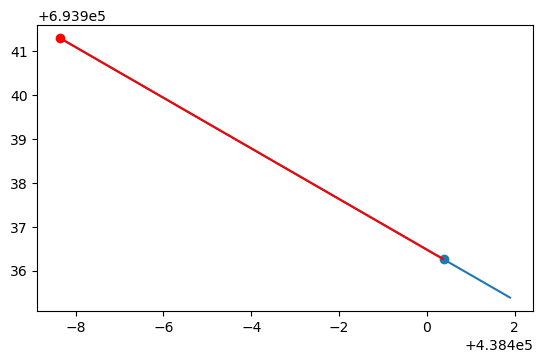

In [93]:
fig,ax=plt.subplots()

starting_point_gdf.plot(ax=ax,color='red')
split_edge_gdf.plot(ax=ax,zorder=1,color='red')
edge_gdf.plot(ax=ax,zorder=0)
clipping_point_gdf.plot(ax=ax,zorder=0)

In [75]:
# 3.2 --------------- Assign the corresponding 'u', 'v' and 'key' data to each edge.
# ------------------- Function edge_clipping() assigns 'starting' to the edge related to the starting_point_gdf
# ------------------- and 'ending' to edge on the opposite side.
u_idx = split_edge_gdf.relation=='starting'
split_edge_gdf.loc[u_idx,'u'] = intersected_u # We assigned 'u' as starting_point_gdf
split_edge_gdf.loc[u_idx,'v'] = intersection_node_osmid # Intersection
split_edge_gdf.loc[u_idx,'key'] = 0 #Since this 'u' and 'v' relation is new, key=0

v_idx = split_edge_gdf.relation=='ending'
split_edge_gdf.loc[v_idx,'u'] = intersection_node_osmid # Intersection
split_edge_gdf.loc[v_idx,'v'] = intersected_v # Opposite side
split_edge_gdf.loc[v_idx,'key'] = 0 #Since this 'u' and 'v' relation is new, key=0

,u,v,key,ntw_join,ntw_origin,geometry
0,644,633,0,0,ntw_01,POINT (438400.385 693936.261)


In [96]:
intersected_edge_id

'6446330'

In [97]:
related_ntw01_edges

,u,v,key,geometry,ntw_join,ntw_origin,edge_id
1275,633,4386435618,0,"LINESTRING (438401.912 693935.380, 438451.082 ...",0,ntw_01,63343864356180
1278,644,633,0,"LINESTRING (438406.204 693959.781, 438400.253 ...",0,ntw_01,6446330


In [98]:
related_ntw02_edges

,u,v,key,geometry,ntw_join,ntw_origin,edge_id
1949,878,1089,0,"LINESTRING (438390.645 693943.026, 438390.651 ...",0,ntw_02,87810890


# NEXT STEPS:
1. Identificar intersecciones que se crean al unir los nodos relacionados, pensar en maneras para solucionarlos.
3. Eliminación de sobrantes
4. Eliminación de redundantes
5. Entrega del resultado
-------------------------------------------
5. Nuevo notebook con todo el procedimiento
6. Nuevo notebook con procedimiento plan B (Más join_nearest, menos buffers), medir tiempos
7. Script
8. Presentación paso a paso del procedimiento

<Axes: >

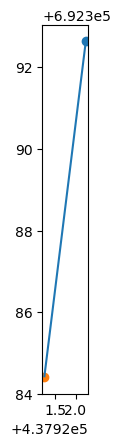

In [89]:
fig,ax = plt.subplots()
connected_node_gdf.plot(ax=ax)
connecting_node_gdf.plot(ax=ax)
line_test.plot(ax=ax)

In [ ]:
# BETTER IDEA OF IMPLEMENTATION:
# 1. Edit function "networks_intersection" implementation so that the function recieves
# -- the relation between intersecting nodes and network (nodes and edges to be intersected).
# -- (Take out of the function the intersection itself) and make the function work for the previous step.
# -- A new accurate name for the function could be "network_splitting"

# 2. While iterating over this part of the code, create that relation gdf (new_node will be the intersecting node,
# -- while the edge to be intersected will be extracted from the nearest edge data)

# 3. Implement the new "network_splitting" function on ntw_01_edges after this part of the code

# 4. Work on "network_joining" function

In [78]:
cn_nearest_u

'1849789133'

In [79]:
cn_nearest_v

144.0

In [80]:
cn_nearest_key

0.0

In [82]:
ntw_01_edges.loc[(ntw_01_edges.u==cn_nearest_u) &(ntw_01_edges.v==cn_nearest_v) & (ntw_01_edges.key==cn_nearest_key)]

,u,v,key,geometry


## __Other code__

In [229]:
new_node

,osmid,geometry,intersecting
0,420.0,POINT (436786.637 692661.902),0.0


In [217]:
produced_osmid

420

In [210]:
edge_v

429642742

In [211]:
edge_key

0

In [197]:
node_distance

54.920676380958426

In [198]:
edge_distance

8.27967409917922

In [185]:
node

osmid                                                 1102.0
geometry         POINT (436973.4942116561 695114.8642968517)
intersecting                                               0
contact                                                    1
osmid_right                                              318
node_distance                                      21.485534
u                                                 4384441676
v                                                      318.0
key                                                      0.0
edge_distance                                       9.514362
Name: 682, dtype: object

In [179]:
edge_distance

8.27967409917922

In [167]:
# Count the number of edges that use this connecting_node
connecting_node_edges = ntw_02_edges.loc[(ntw_02_edges.u==current_osmid) | (ntw_02_edges.v==current_osmid)].copy()
connecting_edges = len(connecting_node_edges)
# Is this connecting_node used only by one edge?
if connecting_edges == 1:
    # Rename as just one edge for code clarity
    connecting_node_edge = connecting_node_edges.copy()
    # Find the opposite osmid
    edge_osmids = [connecting_node_edge.u.unique()[0],connecting_node_edge.v.unique()[0]]
    edge_osmids.remove(current_osmid)
    opposite_osmid = edge_osmids[0]
    
    # Identify if the opposite node is an intersection with the base network.
    opposite_node = ntw_01_nodes.loc[ntw_01_nodes.osmid==opposite_osmid].copy()
    a = """
    if opposite_node['intersecting'] == 1:
        print("a")
        
        # If it is an intersection, get edge length
        edge_length = connecting_node_edge.length.unique()[0]
        # If its length is less than 20 meters, skip present connecting_node.
        # No additional connection needed, there's already a connection to the base network very close.
        if edge_length < 20:
            print("a")
else:
    pass"""

In [169]:
opposite_osmid

510.0

In [156]:
if connecting_edges == 1:
    print("a")

a


## __OLD UNUSED CODE__

In [48]:
# JOIN IDENTIFICATION OLD ORDER
a = """
ntw_01_nodes = boeing_nodes_i.copy()
ntw_01_edges = boeing_edges_i.copy()
ntw_02_nodes = comp_nodes_i.copy()
ntw_02_edges = comp_edges_i.copy()
connecting_nodes = contact_nodes_2.copy()

# Reset produced osmids (not necessary when building Script mode)
previously_produced = 0

# List of nodes created by intersecting both networks
intersecting_idx = ntw_01_nodes.intersecting==1
intersecting_osmids = list(ntw_01_nodes.loc[intersecting_idx].osmid.unique())

# Dictionary of edges that will be edited and the nodes that will be used to edit them
edited_edges = {}

# GeoDataFrame that will store the connections made
connected_nodes = pd.DataFrame()

# Second round of intersections to be created on the network (after this process)
intersection_nodes_2 = gpd.GeoDataFrame()
new_node_idx = 0 #idx of the gdf

extended_logs = False

i = 0
# Iterate over each connecting_node
for idx, node in connecting_nodes.iterrows():

    # Extract current connecting_node's data
    # Current connecting_node data
    cn_osmid = node.osmid 
    cn_geometry = node.geometry
    # nearest_node data
    cn_nearest_osmid = node.osmid_right
    cn_node_distance = node.node_distance 
    #nearest_edge data
    cn_nearest_u = node.u
    cn_nearest_v = node.v
    cn_nearest_key = node.key
    cn_edge_distance = node.edge_distance

    # Development checks -----------------------------------
    #osmid_checks = [1089,1090]
    #if cn_osmid not in osmid_checks:
    #    continue
    #else:
    #    print(cn_osmid)
    # Development checks -----------------------------------
    
    # Register current connecting_node
    connected_nodes.loc[i,'connecting_node'] = cn_osmid
    
    # 1.0 --------------- CASE 1: Close intersection
    # ------------------- Analyse the edges that connect to the current connecting_node.
    # ------------------- If any given edge connects to the base network through an existing network intersection
    # ------------------- in a distance of 20 meters or less, assume there's already an existing connection nerby.
    # ------------------- --> ignore conecting_node (continue).

    # Identify the edges that connect to the current connecting_node
    connecting_node_edges = ntw_02_edges.loc[(ntw_02_edges.u==cn_osmid) | (ntw_02_edges.v==cn_osmid)].copy()
    # Extract the list of nodes ('u' and 'v') that those edges connect to
    connecting_node_osmids = set(list(connecting_node_edges.u.unique()) + list(connecting_node_edges.v.unique()))
    connecting_node_osmids.remove(cn_osmid) #Remove itself
    # Filter for opposite_osmids that are also an intersecting_osmid
    # (Nodes created when intersecting both networks)
    opposite_intersecting_osmid = [osmid for osmid in connecting_node_osmids if osmid in intersecting_osmids]
    # If they exist:
    if len(opposite_intersecting_osmid)>0:
        existing_connection = False
        # Analyse the length of the edges connecting to the opposite_intersecting_osmids. 
        # For any edge connecting to an intersecting_node, if the length of that edge is less than 20 meters, 
        # register that there's already an existing connection nerby.
        edges_to_analyse = connecting_node_edges.loc[(connecting_node_edges.u.isin(opposite_intersecting_osmid)) | 
                                                     (connecting_node_edges.v.isin(opposite_intersecting_osmid))].copy()
        edges_to_analyse['length'] = edges_to_analyse.length
        for edge_length in list(edges_to_analyse.length.unique()):
            if edge_length < 20:
                existing_connection = True
                break
        # If the process found an existing connection, skip current connecting_node
        if existing_connection == True:
            connected_nodes.loc[i,'connection_type'] = 'existing'
            i+=1
            if extended_logs:
                print(f"CASE 1: Connecting node {cn_osmid} already connects to an existing intersection in less than 20 meters.")
            continue # Next connecting_node
    
    # 2.0 --------------- CASE 2: Distance analysis
    # ------------------- If there's no existing intersection nerby, register connection.
    if extended_logs:
        print(f"CASE 2: Connecting node {cn_osmid} has no nerby connection to an existing intersection.")
    
    # 2.1 --------------- New nodes check
    # ------------------- The for loop iterating over connecting_nodes has a code section where new nodes can be created.
    # ------------------- This happens when a connection between a conecting_node and a ntw_01_edge is stablished.
    # ------------------- New nodes can also serve as a connection with between networks
    # ------------------- Considering them prevents multiple connections being created when an existing can be used.

    # IN CASE OF OTHER APPROACH NEEDED STARTS
    # If the case appears, where connecting_node could have had a better connection with a
    # new_node, but it was not considered because the new_node was not located in the nearest edge,
    # consider editing this part of the code so that the check for new nodes is made through a buffer.
    # 1. Find if there are any new nodes in a __x__ meter buffer.
    # 2. If there are, measure distance to all of them and choose the min distance
    # 3. Compare min distance to current distance to nearest node
    # 4. If less, assign new_node as new nearest node.
    # IN CASE OF OTHER APPROACH NEEDED ENDS
    
    # Review nearest edge's data
    cn_edge_id = str(cn_nearest_u)+str(cn_nearest_v)+str(cn_nearest_key)

    # If this edge was already registered as to-be-edited by a new node created on this section of code,
    # check if the new node's distance is lesser than the current nearest node's distance. If so, update.
    if cn_edge_id in edited_edges.keys():
        # Obtain current conecting_node's coordinates
        conecting_nodes_coords = cn_geometry.coords[0]
        # Analyse distance to each newly created node (Created over the nearest edge to current connecting_node)
        registered_nodes = edited_edges[cn_edge_id]
        for node_idx in range(len(registered_nodes)):
            # Obtain registered node's coords
            registered_node = registered_nodes.iloc[node_idx]
            registered_node_coords = registered_node.geometry.coords[0]
            # Calculate distance between nodes
            new_node_distance = distance(conecting_nodes_coords, registered_node_coords)
            # If new_node_distance is less than distance to current nearest node, update nearest node data
            if new_node_distance < cn_node_distance:
                cn_nearest_osmid = registered_node.osmid
                cn_node_distance = new_node_distance
    
    # 2.2 --------------- CASE 2a: Close node connection
    # If distance to nearest node is less than 5 meters, register that connection
    if cn_node_distance<5:
        # Connection registration
        connected_nodes.loc[i,'connection_type'] = 'node'
        connected_nodes.loc[i,'connection_osmid'] = cn_nearest_osmid
        i+=1
        if extended_logs:
            print(f"CASE 2a: Connecting node {cn_osmid} connects to a node in less than 5 meters.")
        continue # Next connecting_node

    # If distance to nearest node is greater than 5 meters, analyse distance to edge
    elif cn_node_distance>5:
        
        # 2.3 --------------- CASE 2a: Edge connection
        # If the nearest_edge is closer than the (nearest_node-5 meters)
        # (Meaning, if the nearest_edge is closer even when we give 5 meter preference to the node over the edge) 
        # --> Create and register join with nearest_edge.
        node_distance_pref = cn_node_distance-5
        if cn_edge_distance < node_distance_pref:

            # 2.3.a) ------------ Create new node
            # Extract the nearest edge's geometry (LineString)
            nearest_edge = ntw_01_edges.loc[(ntw_01_edges.u==cn_nearest_u) & 
                                            (ntw_01_edges.v==cn_nearest_v) &
                                            (ntw_01_edges.key==cn_nearest_key)].copy()
            nearest_edge.reset_index(inplace=True,drop=True)
            edge_geom = nearest_edge['geometry'].unique()[0]
            # Project current connecting_node into the edge's geometry
            projected_point = edge_geom.interpolate(edge_geom.project(cn_geometry))
            # Produce unique osmid
            produced_osmid = produce_osmid(ntw_01_nodes, ntw_02_nodes, previously_produced)
            # TEMP - REMOVE WHEN ntw_01_nodes ARE BEING UPDATED
            previously_produced = produced_osmid+1
            # Create new node on projected point
            new_node = gpd.GeoDataFrame()
            new_node.loc[0,'osmid'] = produced_osmid
            new_node.loc[0,'geometry'] = projected_point
            new_node.loc[0,'intersecting'] = 0
            new_node.loc[0,'created'] = 1
            new_node = new_node.set_crs(projected_crs)
            
            # 2.3.b) ------------ Register new_node and edge to be split by it.
            # ------------------- Will be used in function network_intersections_update()
            # Node that is the intersection (clipping point)
            intersection_nodes.loc[new_node_idx,'osmid'] = produced_osmid
            intersection_nodes.loc[new_node_idx,'geometry'] = projected_point
            # Edge that is intersected
            intersection_nodes.loc[new_node_idx,'u'] = cn_nearest_u
            intersection_nodes.loc[new_node_idx,'v'] = cn_nearest_v
            intersection_nodes.loc[new_node_idx,'key'] = cn_nearest_key
            # Register crs (one time)
            if new_node_idx==0:
                intersection_nodes = intersection_nodes.set_crs(projected_crs)
            # Next idx
            new_node_idx+=1

            # 2.3.c) ------------ Register that this as an edge had a modification on its geometry
            if cn_edge_id in edited_edges.keys():
                # If this edge already had a modification, update modification with new_node
                registered_nodes = edited_edges[cn_edge_id]
                registered_nodes = pd.concat([registered_nodes,new_node])
                registered_nodes.reset_index(inplace=True,drop=True)
                edited_edges[cn_edge_id] = registered_nodes
            
            else:
                # Else, register for the first time
                edited_edges[cn_edge_id] = new_node

            # 2.3.d) ------------ Connection registration
            connected_nodes.loc[i,'connection_type'] = 'node'
            connected_nodes.loc[i,'connection_osmid'] = produced_osmid
            i+=1
            if extended_logs:
                print(f"CASE 2b: Connecting node {cn_osmid} produced a new node in an edge of the network 01.")
            continue # Next connecting_node

        # 2.4 --------------- CASE 2c: Node connection
        # If the (nearest_node-5 meters) is closer than the nearest_edge
        # --> Register node connection
        else:
            # Connection registration
            connected_nodes.loc[i,'connection_type'] = 'node'
            connected_nodes.loc[i,'connection_osmid'] = cn_nearest_osmid
            i+=1
            if extended_logs:
                print(f"CASE 2c: Connecting node {cn_osmid} connects to a node in less than 5 meters.")
            continue # Next connecting_node

# Show
print(connected_nodes.shape)
connected_nodes.head(2)"""

In [50]:
# PROCESS THAT CAN BE USED TO IDENTIFY NODES THAT CONNECT TO ONE EDGE ONLY

a = """
    # Count the number of edges that use this connecting_node
    connecting_node_edges = ntw_02_edges.loc[(ntw_02_edges.u==current_osmid) | (ntw_02_edges.v==current_osmid)].copy()
    connecting_edges = len(connecting_node_edges)
    
    # Is this connecting_node used only by one edge?
    if connecting_edges == 1:
    
        # Rename as just one edge for code clarity
        connecting_node_edge = connecting_node_edges.copy()
    
        # Find the opposite osmid
        edge_osmids = [connecting_node_edge.u.unique()[0],connecting_node_edge.v.unique()[0]]
        edge_osmids.remove(current_osmid)
        opposite_osmid = edge_osmids[0]

        # Identify if the opposite node is an intersection with the base network.
        if opposite_osmid in intersecting_osmids:
            # If it is an intersection, get edge length
            edge_length = connecting_node_edge.length.unique()[0]
            # If its length is less than 20 meters, skip present connecting_node.
            # No additional connection needed, there's already a connection to the base network very close.
            if edge_length < 20:
                print(f"Connecting node {current_osmids} already connects to an existing intersection in less than 20 meters.")
                continue"""